# Results and Graphics

---------------------------------------

In [1]:
from astropy.table import Table, Column, table, vstack, join
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp
from astropy.coordinates import SkyCoord
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import astropy.units as u
import seaborn as sns #For graphic the histograms
import bootstrap_corr as bsc


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:18px !important; }</style>"))

In [2]:
path_raw='../Datos/Raw/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

Reading the data with the Ne line ratios and the results from CIGALE:

In [3]:
Sy_Ne = Table.read(path_FINAL+'Ne_ratios_-_CIGALE_results.tbl', format='ascii')
results = Table.read(path_CIGALE_out+'results0a90_All.fits',format='fits')
Phot = Table.read(path_FINAL+'CIGPhotSy_EnergyBal_All.tbl', format='ascii')

Phot.rename_column('id', 'Main_id')
Phot['CountPoints'] = [sum(~np.isnan(list(j)))/
                       2 for j in Phot[Phot.colnames[2:]].as_array()]
Ne_Sy = join(Phot, Sy_Ne)
print('Total number of galaxies with Ne ratios data: ',len(Ne_Sy))

Total number of galaxies with Ne ratios data:  95


In [4]:
Ne_Sy[0]

Main_id,redshift,FUV,FUV_err,NUV,NUV_err,u_prime,u_prime_err,g_prime,g_prime_err,r_prime,r_prime_err,i_prime,i_prime_err,z_prime,z_prime_err,J_2mass,J_2mass_err,H_2mass,H_2mass_err,Ks_2mass,Ks_2mass_err,WISE1,WISE1_err,IRAC1,IRAC1_err,IRAC2,IRAC2_err,WISE2,WISE2_err,IRAC3,IRAC3_err,IRAC4,IRAC4_err,IRAS1,IRAS1_err,WISE3,WISE3_err,WISE4,WISE4_err,MIPS1,MIPS1_err,IRAS2,IRAS2_err,IRAS3,IRAS3_err,PACS_blue,PACS_blue_err,MIPS2,MIPS2_err,IRAS4,IRAS4_err,PACS_green,PACS_green_err,MIPS3,MIPS3_err,PACS_red,PACS_red_err,PSW_ext,PSW_ext_err,PMW_ext,PMW_ext_err,PLW_ext,PLW_ext_err,CountPoints,RA,DEC,otype,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info
str24,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,str50,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14
2C 94,0.059615,0.041200000850949436,0.008909546,0.05980000059935264,0.008132035999999999,nan,nan,1.0999999940395355,0.05,2.3799999617040157,0.09000000000000001,3.7899999879300594,0.16,nan,nan,3.978181799704378,0.6708949,5.1745456347072665,0.8724677000000001,4.741000244393945,1.0060815,5.957499959130179,0.35744999754781076,5.77,0.17309999999999998,9.045000000000002,0.27135000000000004,7.723522715602409,0.46341136293614454,13.100000000000001,0.393,22.95,0.6885,nan,nan,36.10624933317304,2.166374959990382,109.35000100955367,6.561000060573219,100.04999905824661,4.001999962329864,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17.0,17.220292429510003,13.33729522217,Sy2,*|AGN|G|Rad|Sy2|X,2000000000.0,300000000.0,3900000000.0,200000000.0,0.5128205128205128,0.0812943431354469,2000000000.0,300000000.0,5300000000.0,200000000.0,0.37735849056603776,0.05836748377170459,5300000000.0,200000000.0,3900000000.0,200000000.0,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,1.3787638404047036e+35,5.1210194135958615e+34,2.4468584696260853e+37,4.030152954820804e+36,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547,NeII|NeIII|NeV


## Preparing the data:

### Converting the luminosities from Watts (W) to Solar Luminosities ($L_{\odot}$)

In [5]:
#for cigpar in ['bayes.agn.luminosity', 'bayes.agn.disk_luminosity', 'bayes.agn.dust_luminosity',\
#             'bayes.agn.accretion_power']:
for cigpar in ['bayes.agn.disk_luminosity']:
    Ne_Sy[cigpar] = (Ne_Sy[cigpar]*u.W).to(u.solLum)
    Ne_Sy[cigpar+'_err'] = (Ne_Sy[cigpar+'_err']*u.W).to(u.solLum)

In [6]:
#for cigpar in ['bayes.agn.luminosity', 'bayes.agn.disk_luminosity', 'bayes.agn.dust_luminosity',\
#             'bayes.agn.accretion_power']:
for cigpar2 in ['bayes.agn.luminosity']:
    Ne_Sy[cigpar2] = (Ne_Sy[cigpar2]*u.W).to(u.solLum)
    Ne_Sy[cigpar2+'_err'] = (Ne_Sy[cigpar2+'_err']*u.W).to(u.solLum)

### Logaritmic values and Error Propagation for the Graphics

In the next cell we calculate the logaritmic values for the Ne ratios, the star formation rate and the mass star with their error propagation

In [7]:
log_NeVNeII_Sy = np.log10(Ne_Sy[r'[NeV]/[NeII]*'])
log_NeVNeIII_Sy = np.log10(Ne_Sy[r'[NeV]/[NeIII]$^+$'])
log_NeIIINeII_Sy = np.log10(Ne_Sy[r'[NeIII]/[NeII]$^-$'])
log_sfr_Sy = np.log10(Ne_Sy['bayes.sfh.sfr'])
log_m_star_Sy = np.log10(Ne_Sy['bayes.stellar.m_star'])
log_l_diskAGN = np.log10(Ne_Sy['bayes.agn.disk_luminosity'])
log_l_AGN = np.log10(Ne_Sy['bayes.agn.luminosity'])

log_NeV0 = np.log10(Ne_Sy[r'[NeV]*'])
log_NeII0 = np.log10(Ne_Sy[r'[NeII]*'])
log_NeV1 = np.log10(Ne_Sy[r'[NeV]$^+$'])
log_NeIII1 = np.log10(Ne_Sy[r'[NeIII]$^+$'])
log_NeIII2 = np.log10(Ne_Sy[r'[NeIII]$^-$'])
log_NeII2 = np.log10(Ne_Sy[r'[NeII]$^-$'])

log_NeVNeII_Sy_err = Ne_Sy[r'[NeV]/[NeII]_err*']/(Ne_Sy[r'[NeV]/[NeII]*']*np.log(10))
log_NeVNeIII_Sy_err = Ne_Sy[r'[NeV]/[NeIII]_err$^+$']/(Ne_Sy[r'[NeV]/[NeIII]$^+$']*np.log(10))
log_NeIIINeII_Sy_err = Ne_Sy[r'[NeIII]/[NeII]_err$^-$']/(Ne_Sy[r'[NeIII]/[NeII]$^-$']*np.log(10))
log_sfr_Sy_err = Ne_Sy['bayes.sfh.sfr_err']/(Ne_Sy['bayes.sfh.sfr']*np.log(10))
log_m_star_Sy_err = Ne_Sy['bayes.stellar.m_star_err']/(Ne_Sy['bayes.stellar.m_star']*np.log(10))
log_l_diskAGN_err = Ne_Sy['bayes.agn.disk_luminosity_err']/(Ne_Sy['bayes.agn.disk_luminosity']*np.log(10))
log_l_AGN_err = Ne_Sy['bayes.agn.luminosity_err']/(Ne_Sy['bayes.agn.luminosity']*np.log(10))

log_NeV0_err = Ne_Sy[r'[NeV]_err*']/(Ne_Sy[r'[NeV]*']*np.log(10))
log_NeII0_err = Ne_Sy[r'[NeII]_err*']/(Ne_Sy[r'[NeII]*']*np.log(10))
log_NeV1_err = Ne_Sy[r'[NeV]_err$^+$']/(Ne_Sy[r'[NeV]$^+$']*np.log(10))
log_NeIII1_err = Ne_Sy[r'[NeIII]_err$^+$']/(Ne_Sy[r'[NeIII]$^+$']*np.log(10))
log_NeIII2_err = Ne_Sy[r'[NeIII]_err$^-$']/(Ne_Sy[r'[NeIII]$^-$']*np.log(10))
log_NeII2_err = Ne_Sy[r'[NeII]_err$^-$']/(Ne_Sy[r'[NeII]$^-$']*np.log(10))

#Adding the new values to the table
Ne_Sy['log_[NeV]/[NeII]'] = log_NeVNeII_Sy
Ne_Sy['log_[NeV]/[NeII]_err'] = log_NeVNeII_Sy_err

Ne_Sy['log_[NeV]/[NeIII]'] = log_NeVNeIII_Sy
Ne_Sy['log_[NeV]/[NeIII]_err'] = log_NeVNeIII_Sy_err

Ne_Sy['log_[NeIII]/[NeII]'] = log_NeIIINeII_Sy
Ne_Sy['log_[NeIII]/[NeII]_err'] = log_NeIIINeII_Sy_err

Ne_Sy['log_bayes.sfh.sfr'] = log_sfr_Sy
Ne_Sy['log_bayes.sfh.sfr_err'] = log_sfr_Sy_err

Ne_Sy['log_bayes.stellar.m_star'] = log_m_star_Sy
Ne_Sy['log_bayes.stellar.m_star_err'] = log_m_star_Sy_err

Ne_Sy['log_bayes.agn.disk_luminosity'] = log_l_diskAGN
Ne_Sy['log_bayes.agn.disk_luminosity_err'] = log_l_diskAGN_err

Ne_Sy['log_bayes.agn.luminosity'] = log_l_AGN
Ne_Sy['log_bayes.agn.luminosity_err'] = log_l_AGN_err

Ne_Sy[r'log_[NeV]*'] = log_NeV0
Ne_Sy[r'log_[NeII]*'] = log_NeII0
Ne_Sy[r'log_[NeV]$^+$'] = log_NeV1
Ne_Sy[r'log_[NeIII]$^+$'] = log_NeIII1
Ne_Sy[r'log_[NeIII]$^-$'] = log_NeIII2
Ne_Sy[r'log_[NeII]$^-$'] = log_NeII2

Ne_Sy[r'log_[NeV]_err*'] = log_NeV0_err
Ne_Sy[r'log_[NeII]_err*'] = log_NeII0_err
Ne_Sy[r'log_[NeV]_err$^+$'] = log_NeV1_err
Ne_Sy[r'log_[NeIII]_err$^+$'] = log_NeIII1_err
Ne_Sy[r'log_[NeIII]_err$^-$'] = log_NeIII2_err
Ne_Sy[r'log_[NeII]_err$^-$'] = log_NeII2_err

In [8]:
#Ne_Sy['Main_id','otype','bayes.agn.i','[NeV]/[NeII]','bayes.agn.fracAGN','bayes.agn.disk_luminosity']

### Separating the sample according the Ne ratio info

In [9]:
NeVNeII_Sy = Table(Ne_Sy)
NeVNeII_Sy.remove_rows(np.where(np.isnan(NeVNeII_Sy[r'[NeV]/[NeII]*']))[0])
NeVNeIII_Sy = Table(Ne_Sy)
NeVNeIII_Sy.remove_rows(np.where(np.isnan(NeVNeIII_Sy[r'[NeV]/[NeIII]$^+$']))[0])
NeIIINeII_Sy = Table(Ne_Sy)
NeIIINeII_Sy.remove_rows(np.where(np.isnan(NeIIINeII_Sy[r'[NeIII]/[NeII]$^-$']))[0])

print('From the', len(Ne_Sy),'galaxies of the sample:')
print(len(NeVNeII_Sy),'galaxies have [NeV]/[NeII] info,')
print(len(NeVNeIII_Sy),'galaxies have [NeV]/[NeIII] info,')
print(len(NeIIINeII_Sy),'galaxies have [NeIII]/[NeII] info')

From the 95 galaxies of the sample:
82 galaxies have [NeV]/[NeII] info,
80 galaxies have [NeV]/[NeIII] info,
83 galaxies have [NeIII]/[NeII] info


### Separating the groups in Sy1 and Sy2  (according their classification in SIMBAD)

In [10]:
Ne_Sy1 = Ne_Sy[Ne_Sy['otype']=='Sy1']
Ne_Sy2 = Ne_Sy[Ne_Sy['otype']=='Sy2']
Ne_SyG = Ne_Sy[Ne_Sy['otype']=='SyG']

NeVNeII_Sy1 = NeVNeII_Sy[NeVNeII_Sy['otype']=='Sy1']
NeVNeII_Sy2 = NeVNeII_Sy[NeVNeII_Sy['otype']=='Sy2']
NeVNeII_SyG = NeVNeII_Sy[NeVNeII_Sy['otype']=='SyG']

NeVNeIII_Sy1 = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='Sy1']
NeVNeIII_Sy2 = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='Sy2']
NeVNeIII_SyG = NeVNeIII_Sy[NeVNeIII_Sy['otype']=='SyG']

NeIIINeII_Sy1 = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='Sy1']
NeIIINeII_Sy2 = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='Sy2']
NeIIINeII_SyG = NeIIINeII_Sy[NeIIINeII_Sy['otype']=='SyG']

In [11]:
print('From the', len(Ne_Sy),'galaxies:')
print(len(Ne_Sy1),'galaxies are Seyfert 1,')
print(len(Ne_Sy2),'galaxies are Seyfert 2,')
print(len(Ne_SyG),'galaxies are Seyfert without classification')

From the 95 galaxies:
48 galaxies are Seyfert 1,
47 galaxies are Seyfert 2,
0 galaxies are Seyfert without classification


### Converting tables to pandas to compute the correlations coeficients

For computing the pearson's correlation coeficiens, we will use the function corr from Pandas, so we need to convert the tables to pandas

In [12]:
df_Ne_Sy = Ne_Sy.to_pandas()
df_Ne_Sy1 = Ne_Sy1.to_pandas()
df_Ne_Sy2 = Ne_Sy2.to_pandas()
df_NeVNeII_Sy = NeVNeII_Sy.to_pandas()
df_NeVNeII_Sy1 = NeVNeII_Sy1.to_pandas()
df_NeVNeII_Sy2 = NeVNeII_Sy2.to_pandas()
df_NeVNeIII_Sy = NeVNeIII_Sy.to_pandas()
df_NeVNeIII_Sy1 = NeVNeIII_Sy1.to_pandas()
df_NeVNeIII_Sy2 = NeVNeIII_Sy2.to_pandas()
df_NeIIINeII_Sy = NeIIINeII_Sy.to_pandas()
df_NeIIINeII_Sy1 = NeIIINeII_Sy1.to_pandas()
df_NeIIINeII_Sy2 = NeIIINeII_Sy2.to_pandas()

### Bootstraping function for the correlation coefficients

With the function bootstrapCorr in bootstrap_corr.py (imported as bsc at the begining of this notebook) we compute the correlation coefficient with bootstrapping

-------------------------
### Bins for histograms

The next functions are just to determinate the number of bins for histograms. Maybe this will not be used in all cases because some data have "outliers"

In [13]:
def sturges(data):
    num_data = len(data)
    num_bins = int(np.log2(num_data)) + 1
    return num_bins


def freedman_diaconis(data):
    num_data = len(data)
    irq = np.percentile(data, 75) - np.percentile(data, 25)
    bin_width = 2 * irq / np.power(num_data, 1/3)
    num_bins = int((np.max(data) -  np.min(data)) / bin_width)  + 1
    return num_bins

--------------------------

## Correlations between Neon Emision Lines:

In [14]:
lr_model_Ne = LinearRegression()

X_NeV_0 = df_NeVNeII_Sy[[r'log_[NeV]*']]
y_NeII_0 = df_NeVNeII_Sy[r'log_[NeII]*']

X_NeV_1 = df_NeVNeIII_Sy[[r'log_[NeV]$^+$']]
y_NeIII_1 = df_NeVNeIII_Sy[r'log_[NeIII]$^+$']

X_NeIII_2 = df_NeIIINeII_Sy[[r'log_[NeIII]$^-$']]
y_NeII_2 = df_NeIIINeII_Sy[r'log_[NeII]$^-$']

Nerange = np.linspace(8.5,11,len(Ne_Sy))

NeVNeII_lr = lr_model_Ne.fit(X_NeV_0,y_NeII_0)
y_NeII_0_pred = lr_model_Ne.predict(X_NeV_0)
NeVNeII_rmse = mean_squared_error(y_NeII_0, y_NeII_0_pred, squared=False)
print(r'For [NeV]*/[NeII]*')
print('Coeficient: ',NeVNeII_lr.coef_[0])
print('Intercep: ',NeVNeII_lr.intercept_)
print('Score: ',NeVNeII_lr.score(X_NeV_0,y_NeII_0))
print('RMSE: ',NeVNeII_rmse)
lr_NeVNeII = NeVNeII_lr.coef_[0]*Nerange + NeVNeII_lr.intercept_

NeVNeIII_lr = lr_model_Ne.fit(X_NeV_1, y_NeIII_1)
y_NeIII_1_pred = lr_model_Ne.predict(X_NeV_1)
NeVNeIII_rmse = mean_squared_error(y_NeIII_1, y_NeIII_1_pred, squared=False)
print('\nFor [NeV]+/[NeIII]+')
print('Coeficient: ',NeVNeIII_lr.coef_[0])
print('Intercep: ',NeVNeIII_lr.intercept_)
print('Score: ',NeVNeIII_lr.score(X_NeV_1, y_NeIII_1))
print('RMSE: ',NeVNeIII_rmse)
lr_NeVNeIII = NeVNeIII_lr.coef_[0]*Nerange + NeVNeIII_lr.intercept_

NeIIINeII_lr = lr_model_Ne.fit(X_NeIII_2, y_NeII_2)
y_NeII_2_pred = lr_model_Ne.predict(X_NeIII_2)
NeIIINeII_rmse = mean_squared_error(y_NeII_2, y_NeII_2_pred, squared=False)
print('\nFor [NeIII]-/[NeII]-')
print('Coeficient: ',NeIIINeII_lr.coef_[0])
print('Intercep: ',NeIIINeII_lr.intercept_)
print('Score: ',NeIIINeII_lr.score(X_NeIII_2, y_NeII_2))
print('RMSE: ',NeIIINeII_rmse)
lr_NeIIINeII = NeIIINeII_lr.coef_[0]*Nerange + NeIIINeII_lr.intercept_

For [NeV]*/[NeII]*
Coeficient:  0.8803427763825064
Intercep:  1.3112738475208605
Score:  0.5389605190118757
RMSE:  0.3829124091309258

For [NeV]+/[NeIII]+
Coeficient:  0.9278587403491773
Intercep:  0.9820355420175577
Score:  0.8453288800524522
RMSE:  0.17526198923230307

For [NeIII]-/[NeII]-
Coeficient:  0.9016250825559778
Intercep:  0.8879105956540645
Score:  0.6642991085409122
RMSE:  0.2926397583450014


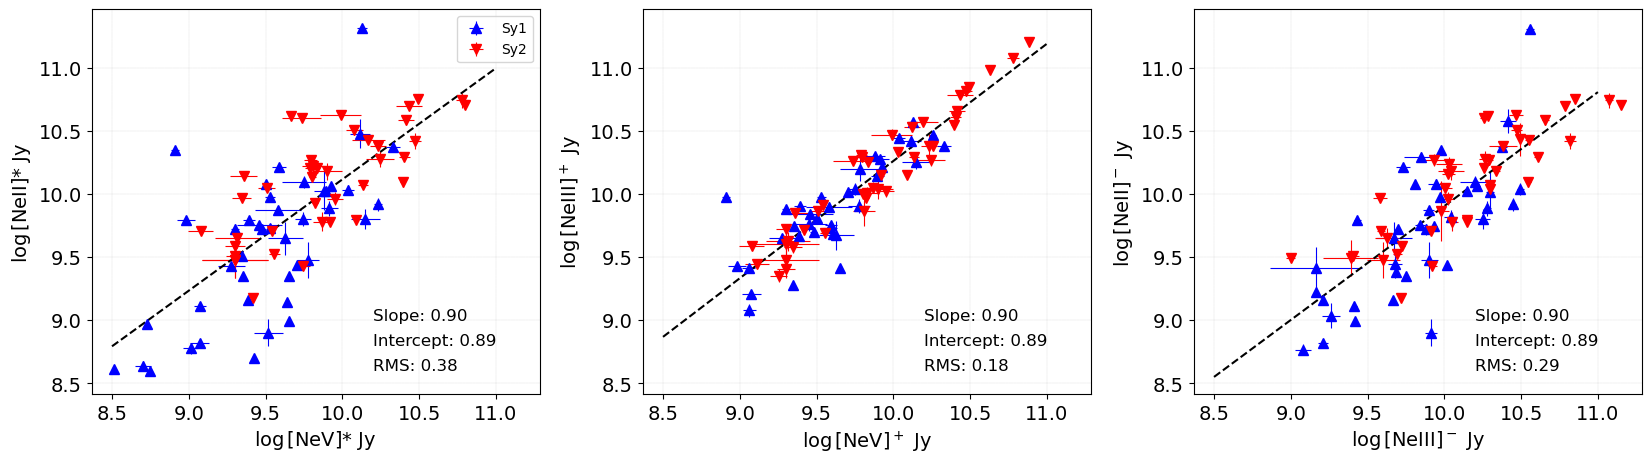

In [15]:
plt.figure(figsize=(20,5))

plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

ax1 = plt.subplot(131)
ax1.errorbar(NeVNeII_Sy1[r'log_[NeV]*'], NeVNeII_Sy1[r'log_[NeII]*'],
             NeVNeII_Sy1[r'log_[NeII]_err*'], NeVNeII_Sy1[r'log_[NeV]_err*'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(NeVNeII_Sy2[r'log_[NeV]*'], NeVNeII_Sy2[r'log_[NeII]*'],
             NeVNeII_Sy2[r'log_[NeII]_err*'], NeVNeII_Sy2[r'log_[NeV]_err*'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax1.plot(Nerange,lr_NeVNeII,'--k')
ax1.set_xlabel(r'$\log$[NeV]* Jy',fontsize=14)
ax1.set_ylabel(r'$\log$[NeII]* Jy',fontsize=14)
ax1.legend()
ax1.text(10.2,9.0,'Slope: %.2f' %NeVNeII_lr.coef_[0],fontsize=12)
ax1.text(10.2,8.8,'Intercept: %.2f' %NeVNeII_lr.intercept_,fontsize=12)
ax1.text(10.2,8.6,'RMS: %.2f' %NeVNeII_rmse,fontsize=12)
ax1.grid(color='k', linestyle='--', linewidth=0.05)

ax2 = plt.subplot(132,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeIII_Sy1[r'log_[NeV]$^+$'], NeVNeIII_Sy1[r'log_[NeIII]$^+$'],
             NeVNeIII_Sy1[r'log_[NeIII]_err$^+$'], NeVNeIII_Sy1[r'log_[NeV]_err$^+$'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.errorbar(NeVNeIII_Sy2[r'log_[NeV]$^+$'], NeVNeIII_Sy2[r'log_[NeIII]$^+$'],
             NeVNeIII_Sy2[r'log_[NeIII]_err$^+$'], NeVNeIII_Sy2[r'log_[NeV]_err$^+$'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax2.plot(Nerange,lr_NeVNeIII,'--k')
ax2.set_xlabel(r'$\log$[NeV]$^+$ Jy',fontsize=14)
ax2.set_ylabel(r'$\log$[NeIII]$^+$ Jy',fontsize=14)
ax2.text(10.2,9.0,'Slope: %.2f' %NeVNeIII_lr.coef_[0],fontsize=12)
ax2.text(10.2,8.8,'Intercept: %.2f' %NeVNeIII_lr.intercept_,fontsize=12)
ax2.text(10.2,8.6,'RMS: %.2f' %NeVNeIII_rmse,fontsize=12)
ax2.grid(color='k', linestyle='--', linewidth=0.05)

ax3 = plt.subplot(133,sharex=ax1,sharey=ax1)
ax3.errorbar(NeIIINeII_Sy1[r'log_[NeIII]$^-$'], NeIIINeII_Sy1[r'log_[NeII]$^-$'],
             NeIIINeII_Sy1[r'log_[NeII]_err$^-$'],NeIIINeII_Sy1[r'log_[NeIII]_err$^-$'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax3.errorbar(NeIIINeII_Sy2[r'log_[NeIII]$^-$'], NeIIINeII_Sy2[r'log_[NeII]$^-$'],
             NeIIINeII_Sy2[r'log_[NeII]_err$^-$'],NeIIINeII_Sy2[r'log_[NeIII]_err$^-$'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.plot(Nerange,lr_NeIIINeII,'--k')
ax3.set_xlabel(r'$\log$[NeIII]$^-$ Jy',fontsize=14)
ax3.set_ylabel(r'$\log$[NeII]$^-$ Jy',fontsize=14)
ax3.text(10.2,9.0,'Slope: %.2f' %NeIIINeII_lr.coef_[0],fontsize=12)
ax3.text(10.2,8.8,'Intercept: %.2f' %NeIIINeII_lr.intercept_,fontsize=12)
ax3.text(10.2,8.6,'RMS: %.2f' %NeIIINeII_rmse,fontsize=12)
ax3.grid(color='k', linestyle='--', linewidth=0.05)

plt.subplots_adjust(wspace=0.23) #Space between subplots

plt.show()

## Histogram Line Ratios:

<Figure size 2000x500 with 0 Axes>

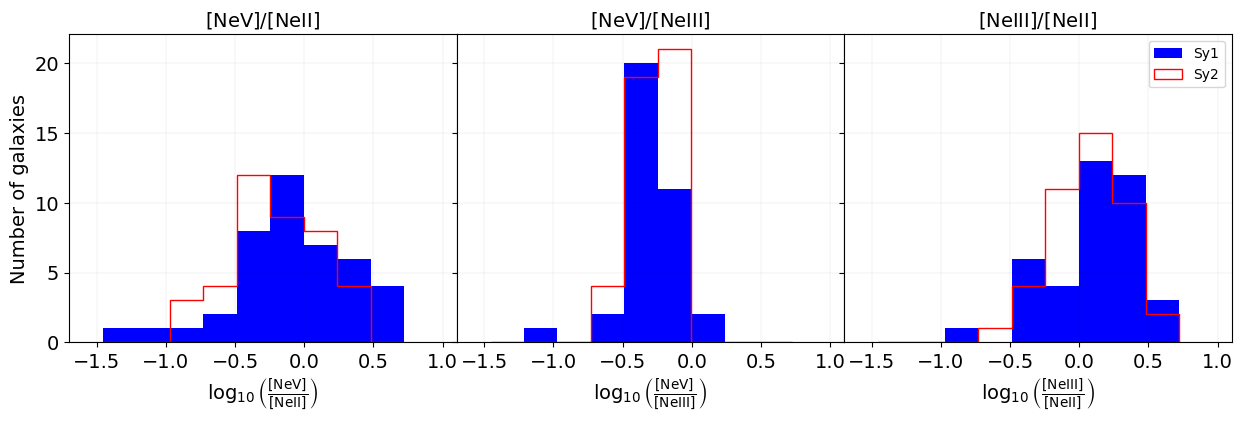

In [16]:
bins = np.linspace(min(NeVNeII_Sy['log_[NeV]/[NeII]']),max(NeVNeII_Sy['log_[NeV]/[NeII]']),10)#len(NeVNeII_Sy)
#bins = sturges(NeVNeII_Sy['log_[NeV]/[NeII]'])

plt.figure(figsize=(20,5))
fig, axs = plt.subplots(1,3,figsize=(15,4),sharey='row')

axs[0].hist(NeVNeII_Sy1['log_[NeV]/[NeII]'], bins=bins,color='b',histtype='bar',label='Sy1')
axs[0].hist(NeVNeII_Sy2['log_[NeV]/[NeII]'], bins=bins,color='r',histtype='step', label='Sy2')
axs[0].set_xlim(-1.7,1.1)
axs[0].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
axs[0].set_ylabel('Number of galaxies',fontsize=14)
axs[0].set_title(r'$\mathregular{[NeV]} / \mathregular{[NeII]}$', fontsize=14)
#axs[0].legend()
axs[0].grid(color='k', linestyle='--', linewidth=0.05)

axs[1].hist(NeVNeIII_Sy1['log_[NeV]/[NeIII]'], bins=bins,color='b',label='Sy1')
axs[1].hist(NeVNeIII_Sy2['log_[NeV]/[NeIII]'], bins=bins,color='r',histtype='step', label='Sy2')
axs[1].set_xlim(-1.7,1.1)
axs[1].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeIII]}}\right)$',fontsize=14)
#axs[1].set_ylabel('Number of galaxies',fontsize=14)
axs[1].set_title(r'$\mathregular{[NeV]} / \mathregular{[NeIII]}$', fontsize=14)
axs[1].grid(color='k', linestyle='--', linewidth=0.05)
#axs[1].legend()

axs[2].hist(NeIIINeII_Sy1['log_[NeIII]/[NeII]'], bins=bins,color='b',label='Sy1')
axs[2].hist(NeIIINeII_Sy2['log_[NeIII]/[NeII]'], bins=bins,color='r',histtype='step', label='Sy2')
axs[2].set_xlim(-1.7,1.1)
axs[2].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeIII]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
#axs[2].set_ylabel('Number of galaxies',fontsize=14)
axs[2].set_title(r'$\mathregular{[NeIII]} / \mathregular{[NeII]}$', fontsize=14)
axs[2].grid(color='k', linestyle='--', linewidth=0.05)
axs[2].legend()

plt.subplots_adjust(wspace=0.0) #Space between subplots

plt.savefig(path_graphs+'histos_Ne_ratios_Sy.jpg')

----------------------------------------

# [NeV]/[NeII]

In [17]:
print('From the', len(NeVNeII_Sy),'galaxies with [NeV]/[NeII] info:')
print(len(NeVNeII_Sy1),'galaxies are Seyfert 1,')
print(len(NeVNeII_Sy2),'galaxies are Seyfert 2,')

From the 82 galaxies with [NeV]/[NeII] info:
42 galaxies are Seyfert 1,
40 galaxies are Seyfert 2,


## [NeV]/[NeII] vs AGN Fraction

### Correlation Coefficients:

In [18]:
NeVNeII_corr_fracAGN_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['bayes.agn.fracAGN'])
NeVNeII_corr_fracAGN_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['bayes.agn.fracAGN'])
NeVNeII_corr_fracAGN_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('Total Sample: ',NeVNeII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeVNeII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeVNeII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
Total Sample:  0.5117530389435666
Seyfert 1:  0.6576009304823218
Seyfert 2:  0.2927044896469459


In [19]:
NeVNeII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy[0]),'max:',max(NeVNeII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 66 of 82
Number of samples: 10000
Median: 0.5119751017121356
Mean: 0.5058548368096745
Variance: 0.009116627488391519
Standard Desviation: 0.09548103208696226
90 % confidence interval: 0.33953873780965416 - 0.6530769271508531
min: 0.13730224271803543 max: 0.782754095363569


In [20]:
NeVNeII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy1[0]),'max:',max(NeVNeII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 34 of 42
Number of samples: 10000
Median: 0.6567616884266966
Mean: 0.6411186780849785
Variance: 0.012630704300678839
Standard Desviation: 0.11238640620946484
90 % confidence interval: 0.4293766984307031 - 0.7945837133344879
min: 0.0589711026563488 max: 0.9066217425596218


In [21]:
NeVNeII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,0.8,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeVNeII_fracAGN_Sy2[0]),'max:',max(NeVNeII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 32 of 40
Number of samples: 10000
Median: 0.29832457434244186
Mean: 0.29419144958881016
Variance: 0.021695069877829366
Standard Desviation: 0.14729246375096508
90 % confidence interval: 0.04643369396130231 - 0.5312428226373229
min: -0.2608086844838094 max: 0.7571177694019722


### Lineal Regressions

In [22]:
lr_model = LinearRegression()

X_Sy = df_NeVNeII_Sy[['log_[NeV]/[NeII]']]
y_Sy = df_NeVNeII_Sy['bayes.agn.fracAGN']

X_Sy1 = df_NeVNeII_Sy1[['log_[NeV]/[NeII]']]
y_Sy1 = df_NeVNeII_Sy1['bayes.agn.fracAGN']

X_Sy2 = df_NeVNeII_Sy2[['log_[NeV]/[NeII]']]
y_Sy2 = df_NeVNeII_Sy2['bayes.agn.fracAGN']

NeVNeIIrange = np.linspace(min(NeVNeII_Sy['log_[NeV]/[NeII]']),max(NeVNeII_Sy['log_[NeV]/[NeII]']),len(NeVNeII_Sy['log_[NeV]/[NeII]']))

NeVNeII_lr_Sy = lr_model.fit(X_Sy, y_Sy)
print('For all SyG')
print('Coeficient: ',NeVNeII_lr_Sy.coef_[0])
print('Intercep: ',NeVNeII_lr_Sy.intercept_)
print('Score: ',NeVNeII_lr_Sy.score(X_Sy, y_Sy))
lr_Sy = NeVNeII_lr_Sy.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy.intercept_

NeVNeII_lr_Sy1 = lr_model.fit(X_Sy1, y_Sy1)
print('\nFor Sy1')
print('Coeficient: ',NeVNeII_lr_Sy1.coef_[0])
print('Intercep: ',NeVNeII_lr_Sy1.intercept_)
print('Score: ',NeVNeII_lr_Sy1.score(X_Sy1, y_Sy1))
lr_Sy1 = NeVNeII_lr_Sy1.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy1.intercept_

NeVNeII_lr_Sy2 = lr_model.fit(X_Sy2, y_Sy2)
print('\nFor Sy2')
print('Coeficient: ',NeVNeII_lr_Sy2.coef_[0])
print('Intercep: ',NeVNeII_lr_Sy2.intercept_)
print('Score: ',NeVNeII_lr_Sy2.score(X_Sy2, y_Sy2))
lr_Sy2 = NeVNeII_lr_Sy2.coef_[0]*NeVNeIIrange + NeVNeII_lr_Sy2.intercept_

For all SyG
Coeficient:  0.30109830879942145
Intercep:  0.6626194989896103
Score:  0.2618911728679756

For Sy1
Coeficient:  0.33863645971640405
Intercep:  0.6786221770245864
Score:  0.4324389837712155

For Sy2
Coeficient:  0.20998701004870976
Intercep:  0.6302881928872041
Score:  0.08567591825947896


-----------------
Some common parameters for the graphics of the Neon Line Ratios vs $f_{AGN}$:

In [23]:
#Labels text and fontsize for the graphics of Ne Ratios vs fAGN:
xr_label = r'Pearson correlation coefficient (PCC)'
yl_label = r'$f_{AGN}$'
yr_label = r'Density'
fontsize_labels = 14

#Aggregate statistic to compute in each bin in the histograms
#Options: count, frequency, probability, percent and density
stat = 'density'

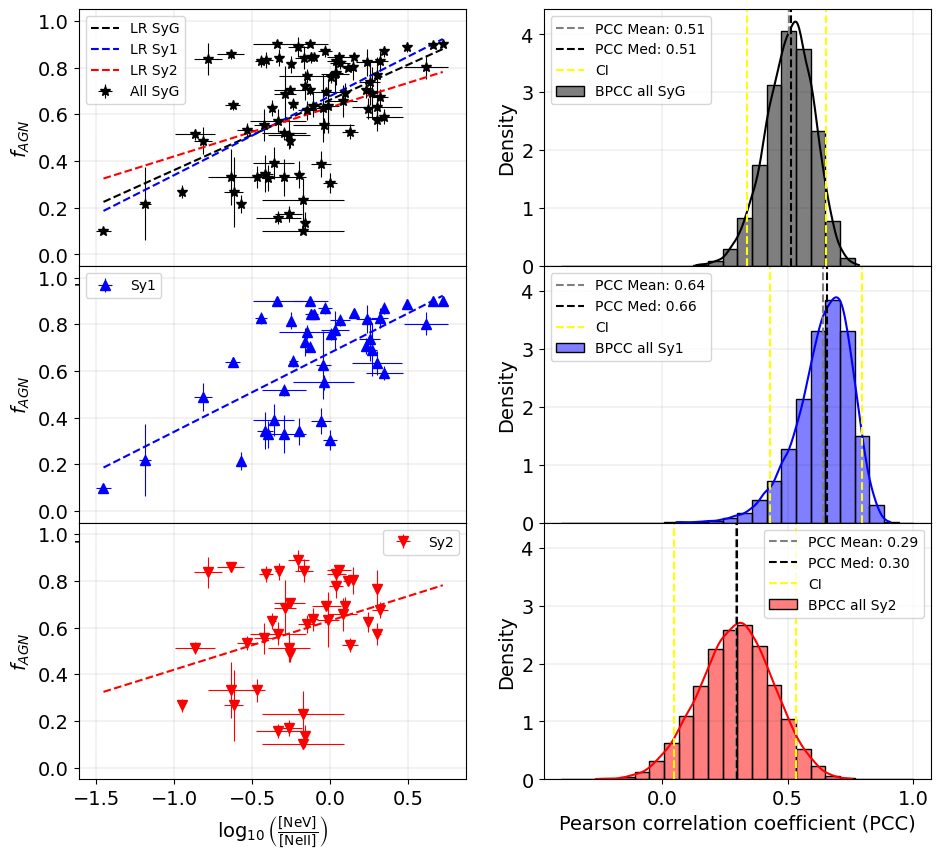

In [24]:
plt.figure(figsize=(11,10))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

ax1 = plt.subplot(321)
ax1.errorbar(NeVNeII_Sy['log_[NeV]/[NeII]'], NeVNeII_Sy['bayes.agn.fracAGN'],NeVNeII_Sy['bayes.agn.fracAGN_err'], NeVNeII_Sy['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.plot(NeVNeIIrange,lr_Sy,'--k',label='LR SyG')
ax1.plot(NeVNeIIrange,lr_Sy1,'--b',label='LR Sy1')
ax1.plot(NeVNeIIrange,lr_Sy2,'--r',label='LR Sy2')
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.1)

ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['bayes.agn.fracAGN_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.plot(NeVNeIIrange,lr_Sy1,'--b')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.1)

ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['bayes.agn.fracAGN'],NeVNeII_Sy2['bayes.agn.fracAGN_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.plot(NeVNeIIrange,lr_Sy2,'--r')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.1)

bins = np.linspace(-0.4,1.0,25)
binsSy = sturges(NeVNeII_fracAGN_Sy[0])
binsSy1 = sturges(NeVNeII_fracAGN_Sy1[0])
binsSy2 = sturges(NeVNeII_fracAGN_Sy2[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(322)
sns.histplot(NeVNeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeII_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC all Sy1')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC all Sy2')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.2) #Space between subplots
plt.savefig(path_graphs+'NeV_NeII_vs_fracAGN_Sy1_vs_Sy2.jpg')

Same graphic above, but in horizontal plot:

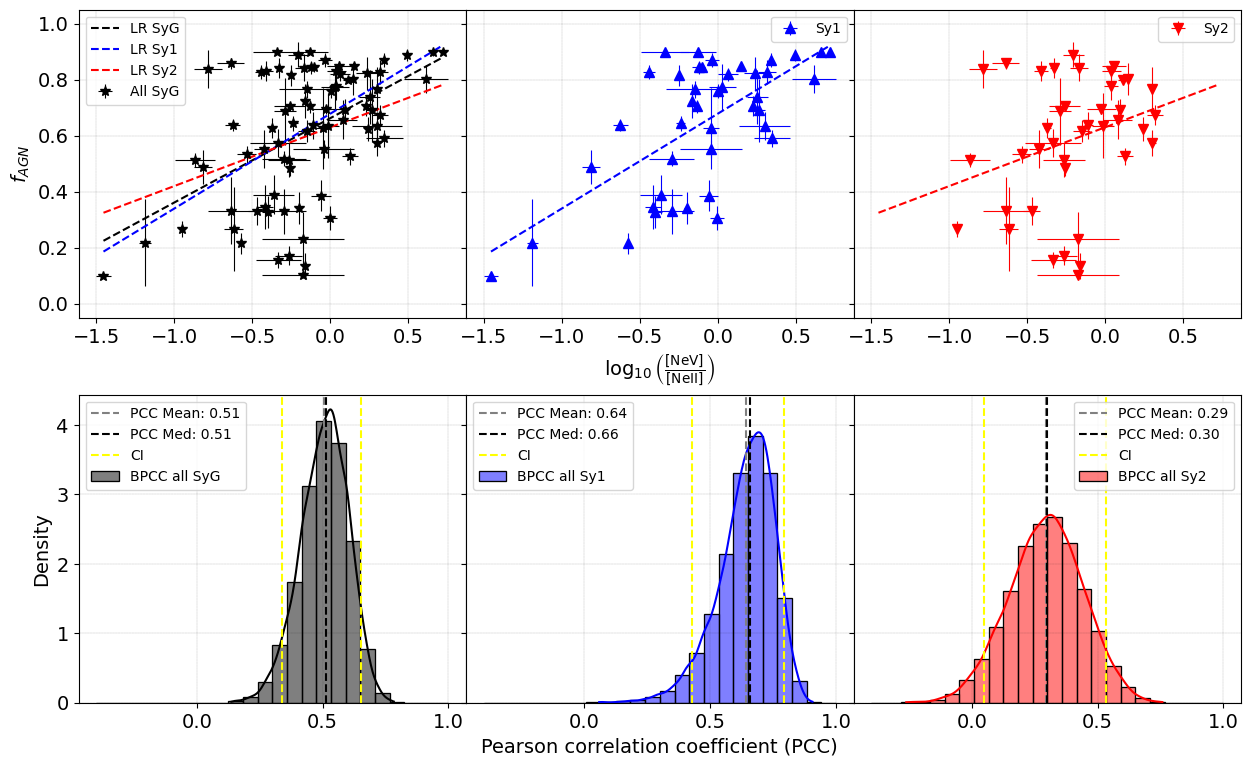

In [25]:
plt.figure(figsize=(15,9))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

ax1 = plt.subplot(231)
ax1.errorbar(NeVNeII_Sy['log_[NeV]/[NeII]'], NeVNeII_Sy['bayes.agn.fracAGN'],NeVNeII_Sy['bayes.agn.fracAGN_err'], NeVNeII_Sy['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.plot(NeVNeIIrange,lr_Sy,'--k',label='LR SyG')
ax1.plot(NeVNeIIrange,lr_Sy1,'--b',label='LR Sy1')
ax1.plot(NeVNeIIrange,lr_Sy2,'--r',label='LR Sy2')
#ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.1)

ax2 = plt.subplot(232,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['bayes.agn.fracAGN_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.plot(NeVNeIIrange,lr_Sy1,'--b')
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax2.yaxis.set_tick_params(labelleft=False)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.1)

ax3 = plt.subplot(233,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['bayes.agn.fracAGN'],NeVNeII_Sy2['bayes.agn.fracAGN_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.plot(NeVNeIIrange,lr_Sy2,'--r')
#ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax3.yaxis.set_tick_params(labelleft=False)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.1)

bins = np.linspace(-0.4,1.0,25)
#bins = sturges(NeVNeII_fracAGN_Sy[0])
#bins = freedman_diaconis(NeVNeII_fracAGN_Sy[0])

ax4 = plt.subplot(234)
sns.histplot(NeVNeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeII_fracAGN_Sy[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeII_fracAGN_Sy[5],ls='--',color='yellow')
#ax4.set_xlabel(xr_label,fontsize=fontsize_labels)
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(235,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC all Sy1')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_xlabel(xr_label,fontsize=fontsize_labels)
ax5.set(ylabel=None)
ax5.yaxis.set_tick_params(labelleft=False)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(236,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC all Sy2')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[3],ls='--',color='black',label='PCC Med: %.2f' %NeVNeII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeII_fracAGN_Sy2[5],ls='--',color='yellow')
#ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set(ylabel=None)
ax6.yaxis.set_tick_params(labelleft=False)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.25,wspace=0.0) #Space between subplots

## [NeV]/[NeII] vs other parameters (from CIGALE)

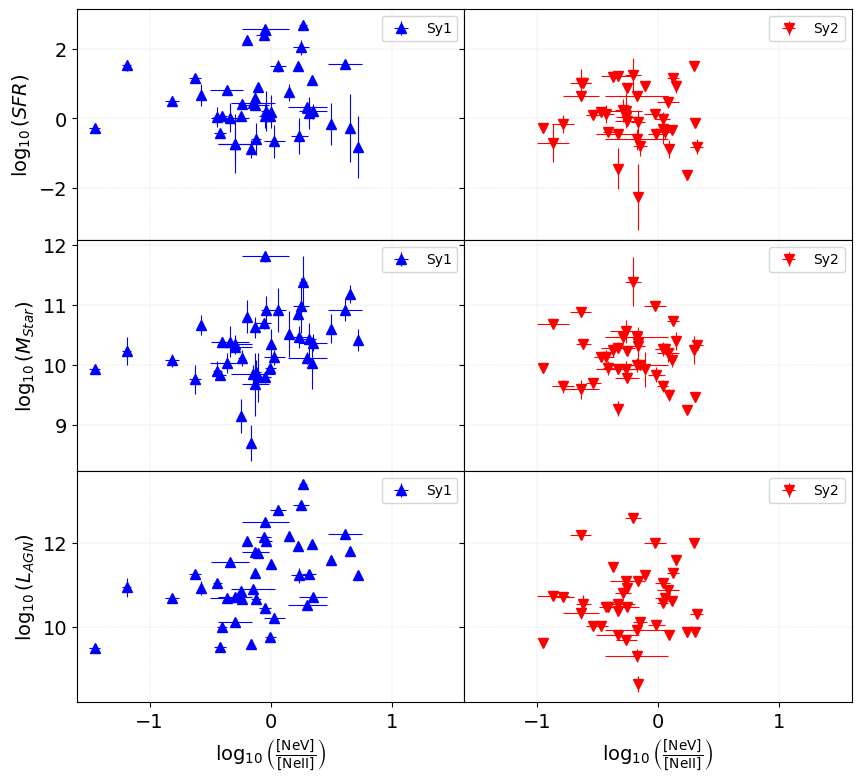

In [25]:
fig, axs = plt.subplots(3,2,figsize=(10,9),sharex='col',sharey='row')
#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

axs[0,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.sfh.sfr'],
                  NeVNeII_Sy1['log_bayes.sfh.sfr_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[0,0].set_ylabel(r'$\log_{10}(SFR)$', fontsize=14)
axs[0,0].set_xlim(-1.6,1.6)
axs[0,0].legend()
axs[0,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[0,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.sfh.sfr'],
                  NeVNeII_Sy2['log_bayes.sfh.sfr_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[0,1].set_xlim(-1.6,1.6)
axs[0,1].legend()
axs[0,1].grid(color='k', linestyle='--', linewidth=0.05)

axs[1,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.stellar.m_star'],
                  NeVNeII_Sy1['log_bayes.stellar.m_star_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[1,0].set_ylabel(r'$\log_{10}(M_{Star})$', fontsize=14)
axs[1,0].legend()
axs[1,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[1,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.stellar.m_star'],
                  NeVNeII_Sy2['log_bayes.stellar.m_star_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[1,1].legend()
axs[1,1].grid(color='k', linestyle='--', linewidth=0.05)

axs[2,0].errorbar(NeVNeII_Sy1['log_[NeV]/[NeII]'], NeVNeII_Sy1['log_bayes.agn.luminosity'],
                  NeVNeII_Sy1['log_bayes.agn.luminosity_err'], NeVNeII_Sy1['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
axs[2,0].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
axs[2,0].set_ylabel(r'$\log_{10}(L_{AGN})$', fontsize=14)
axs[2,0].legend()
axs[2,0].grid(color='k', linestyle='--', linewidth=0.05)

axs[2,1].errorbar(NeVNeII_Sy2['log_[NeV]/[NeII]'], NeVNeII_Sy2['log_bayes.agn.luminosity'],
                  NeVNeII_Sy2['log_bayes.agn.luminosity_err'], NeVNeII_Sy2['log_[NeV]/[NeII]_err'],
                  markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
axs[2,1].set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$',fontsize=14)
axs[2,1].legend()
axs[2,1].grid(color='k', linestyle='--', linewidth=0.05)


plt.subplots_adjust(hspace=0.0,wspace=0.0) #Space between subplots

### Correlation SFR:

In [26]:
NeVNeII_corr_SFR_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.sfh.sfr'])
NeVNeII_corr_SFR_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.sfh.sfr'])
NeVNeII_corr_SFR_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.sfh.sfr'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and Star Forming Rate:')
print('Total Sample: ',NeVNeII_corr_SFR_Sy)
print('Seyfert 1: ',NeVNeII_corr_SFR_Sy1)
print('Seyfert 2: ',NeVNeII_corr_SFR_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and Star Forming Rate:
Total Sample:  0.032358634951446724
Seyfert 1:  0.039911514993654175
Seyfert 2:  -0.08220104651402141


In [27]:
print('All Seyfert Galaxies:')
NeVNeII_SFR_Sy = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')
print('\nSeyfert 1:')
NeVNeII_SFR_Sy1 = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')
print('\nSeyfert 2:')
NeVNeII_SFR_Sy2 = bsc.bootstrapCorr(10000,1,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','log_bayes.sfh.sfr')

All Seyfert Galaxies:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 82 of 82
Number of samples: 10000
Median: 0.03413718378887604
Mean: 0.0320484338067149
Variance: 0.011283513894922102
Standard Desviation: 0.10622388570807463
90 % confidence interval: -0.14650703955519012 - 0.20203684852614717

Seyfert 1:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 42 of 42
Number of samples: 10000
Median: 0.041735687543955874
Mean: 0.03782754468185476
Variance: 0.021441206372650883
Standard Desviation: 0.14642816113251877
90 % confidence interval: -0.20843592755526266 - 0.2752873945750087

Seyfert 2:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.sfh.sfr :
Samples lenght: 40 of 40
Number of samples: 10000
Median: -0.086734793673871
Mean: -0.08771526432138757
Variance: 0.024749565556820948
Standard Desviation: 0.1573199464684

### Correlation $M_{star}$:

In [28]:
NeVNeII_corr_m_star_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.stellar.m_star'])
NeVNeII_corr_m_star_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.stellar.m_star'])
NeVNeII_corr_m_star_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and Star Mass:')
print('Total Sample: ',NeVNeII_corr_m_star_Sy)
print('Seyfert 1: ',NeVNeII_corr_m_star_Sy1)
print('Seyfert 2: ',NeVNeII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and Star Mass:
Total Sample:  0.23862348785855922
Seyfert 1:  0.36543437601265155
Seyfert 2:  -0.051934160313952725


In [29]:
print('All Seyfert Galaxies:')
NeVNeII_m_star_Sy = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')
print('\nSeyfert 1:')
NeVNeII_m_star_Sy1 = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy1,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')
print('\nSeyfert 2:')
NeVNeII_m_star_Sy2 = bsc.bootstrapCorr(10000,0.7,df_NeVNeII_Sy2,'log_[NeV]/[NeII]','log_bayes.stellar.m_star')

All Seyfert Galaxies:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 57 of 82
Number of samples: 10000
Median: 0.24050617865999013
Mean: 0.23895104796126476
Variance: 0.011894007156245423
Standard Desviation: 0.10905964953292956
90 % confidence interval: 0.05792186922213119 - 0.4156625708155878

Seyfert 1:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 29 of 42
Number of samples: 10000
Median: 0.37810819778103855
Mean: 0.37696659098255775
Variance: 0.011164412761377814
Standard Desviation: 0.10566178477282036
90 % confidence interval: 0.2024849820990384 - 0.5499105505605549

Seyfert 2:
Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y log_bayes.stellar.m_star :
Samples lenght: 28 of 40
Number of samples: 10000
Median: -0.044413549872115765
Mean: -0.04305474704932046
Variance: 0.04113828400328872
Standard Desviati

### Correlation $L_{\text{AGN}}$:

In [30]:
NeVNeII_corr_lagn_Sy = df_NeVNeII_Sy['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy['log_bayes.agn.luminosity'])
NeVNeII_corr_lagn_Sy1 = df_NeVNeII_Sy1['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy1['log_bayes.agn.luminosity'])
NeVNeII_corr_lagn_Sy2 = df_NeVNeII_Sy2['log_[NeV]/[NeII]'].corr(df_NeVNeII_Sy2['log_bayes.agn.luminosity'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN luminosity:')
print('Total Sample: ',NeVNeII_corr_lagn_Sy)
print('Seyfert 1: ',NeVNeII_corr_lagn_Sy1)
print('Seyfert 2: ',NeVNeII_corr_lagn_Sy2)


Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN luminosity:
Total Sample:  0.35343847538841294
Seyfert 1:  0.4650042404359145
Seyfert 2:  0.09148258335918706


--------------------------------------

# [NeV]/[NeIII]

In [31]:
print('From the', len(NeVNeIII_Sy),'galaxies with [NeV]/[NeIII] info:')
print(len(NeVNeIII_Sy1),'galaxies are Seyfert 1,')
print(len(NeVNeIII_Sy2),'galaxies are Seyfert 2,')

From the 80 galaxies with [NeV]/[NeIII] info:
36 galaxies are Seyfert 1,
44 galaxies are Seyfert 2,


## [NeV]/[NeIII] vs AGN Fraction

### Correlation Coefficients:

In [32]:
NeVNeIII_corr_fracAGN_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['bayes.agn.fracAGN'])
NeVNeIII_corr_fracAGN_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['bayes.agn.fracAGN'])
NeVNeIII_corr_fracAGN_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeIII] ratio and AGN fraction:')
print('Total Sample: ',NeVNeIII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeVNeIII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeV]/[NeIII] ratio and AGN fraction:
Total Sample:  0.32775146553453605
Seyfert 1:  0.5098878980360981
Seyfert 2:  0.11212932939372912


In [33]:
NeVNeIII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeVNeIII_Sy,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy[0]),'max:',max(NeVNeIII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 64 of 80
Number of samples: 10000
Median: 0.3231763290296642
Mean: 0.3150752282891498
Variance: 0.01685928743300182
Standard Desviation: 0.12984331878460986
90 % confidence interval: 0.08622165792367628 - 0.517367790213554
min: -0.21007143185648636 max: 0.724457372050464


In [34]:
NeVNeIII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeVNeIII_Sy1,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy1[0]),'max:',max(NeVNeIII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 29 of 36
Number of samples: 10000
Median: 0.5018474565197288
Mean: 0.47863807267658465
Variance: 0.027363597405057293
Standard Desviation: 0.16541945896736965
90 % confidence interval: 0.1681796005898625 - 0.7100266981064963
min: -0.30079969289916153 max: 0.8567140734860884


In [35]:
NeVNeIII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,1,df_NeVNeIII_Sy2,'log_[NeV]/[NeIII]','bayes.agn.fracAGN')
print('min:',min(NeVNeIII_fracAGN_Sy2[0]),'max:',max(NeVNeIII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeV]/[NeIII] y bayes.agn.fracAGN :
Samples lenght: 44 of 44
Number of samples: 10000
Median: 0.11611980777662635
Mean: 0.1158149360002694
Variance: 0.022603829689711336
Standard Desviation: 0.15034570060268213
90 % confidence interval: -0.1331734741584072 - 0.3609234773438987
min: -0.45763102747304596 max: 0.6887868765633791


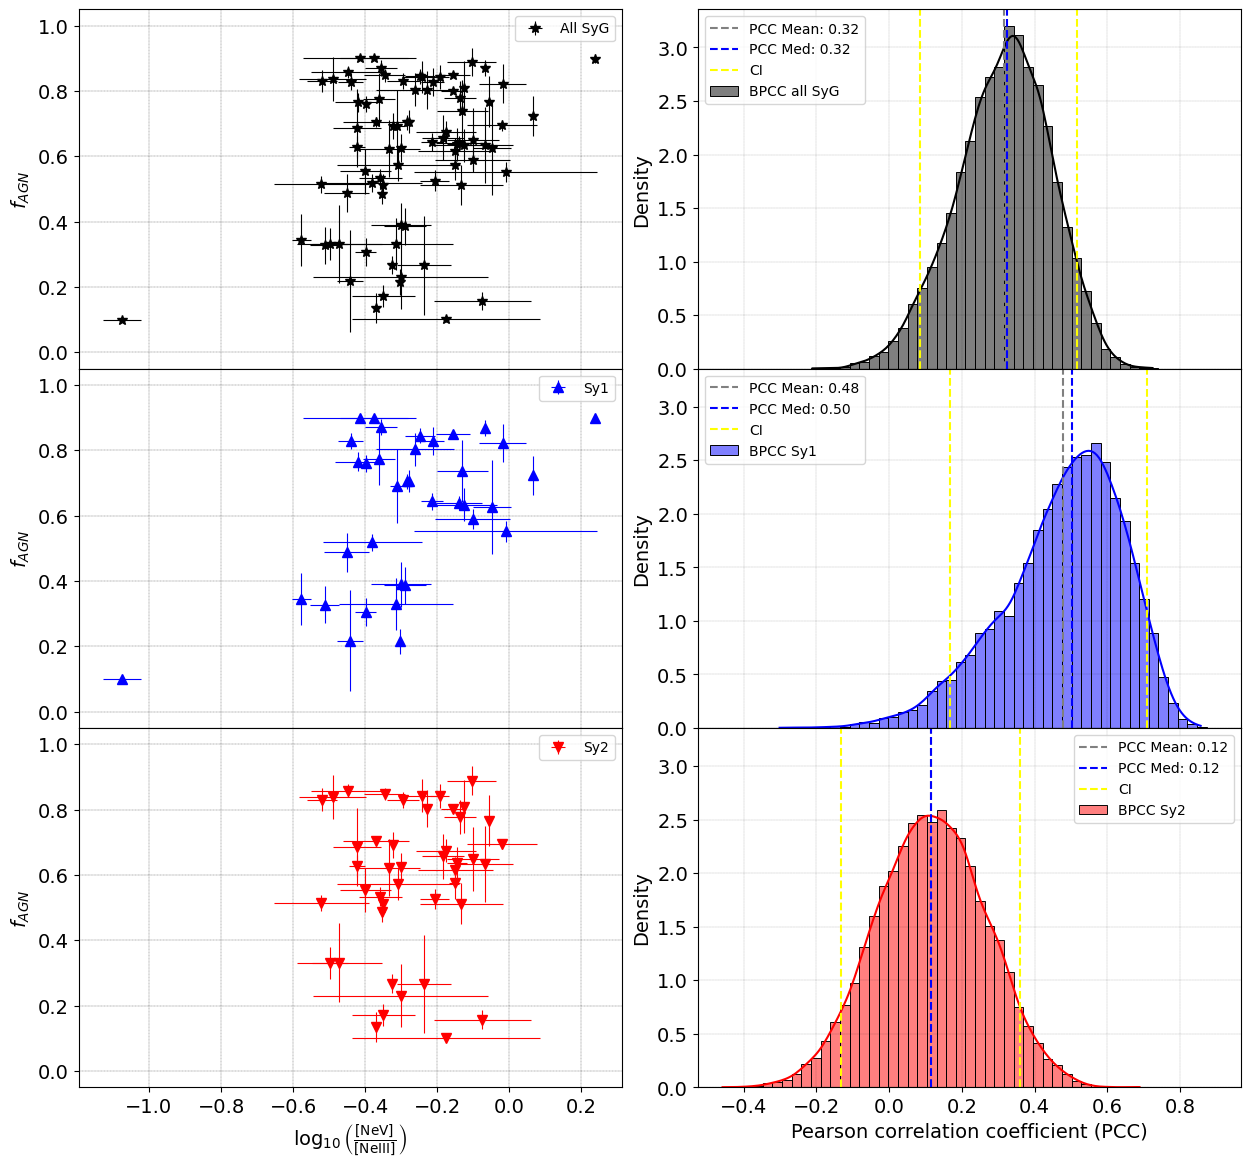

In [36]:
plt.figure(figsize=(15,14))
#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeIII]}$', fontsize=16)

ax1 = plt.subplot(321)
ax1.errorbar(NeVNeIII_Sy['log_[NeV]/[NeIII]'], NeVNeIII_Sy['bayes.agn.fracAGN'],NeVNeIII_Sy['bayes.agn.fracAGN_err'], NeVNeIII_Sy['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.2)

ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeVNeIII_Sy1['log_[NeV]/[NeIII]'], NeVNeIII_Sy1['bayes.agn.fracAGN'],NeVNeIII_Sy1['bayes.agn.fracAGN_err'], NeVNeIII_Sy1['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeVNeIII_Sy2['log_[NeV]/[NeIII]'], NeVNeIII_Sy2['bayes.agn.fracAGN'],NeVNeIII_Sy2['bayes.agn.fracAGN_err'], NeVNeIII_Sy2['log_[NeV]/[NeIII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeIII]}}\right)$', fontsize=fontsize_labels)
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.2)

bins = np.linspace(-0.4,0.9,50)

ax4 = plt.subplot(322)
sns.histplot(NeVNeIII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeVNeIII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy[1])
ax4.axvline(x=NeVNeIII_fracAGN_Sy[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy[3])
ax4.axvline(x=NeVNeIII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeVNeIII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeIII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC Sy1')
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy1[1])
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy1[3])
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeVNeIII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeVNeIII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC Sy2')
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeVNeIII_fracAGN_Sy2[1])
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[3],ls='--',color='blue',label='PCC Med: %.2f' %NeVNeIII_fracAGN_Sy2[3])
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeVNeIII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.14) #Space between subplots
plt.savefig(path_graphs+'NeV_NeIII_vs_fracAGN_Sy1_vs_Sy2.jpg')

## [NeV]/[NeIII] vs other variables (outputs from CIGALE)

In [37]:
NeVNeIII_corr_SFR_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['log_bayes.sfh.sfr'])
NeVNeIII_corr_SFR_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['log_bayes.sfh.sfr'])
NeVNeIII_corr_SFR_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['log_bayes.sfh.sfr'])

NeVNeIII_corr_m_star_Sy = df_NeVNeIII_Sy['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy['log_bayes.stellar.m_star'])
NeVNeIII_corr_m_star_Sy1 = df_NeVNeIII_Sy1['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy1['log_bayes.stellar.m_star'])
NeVNeIII_corr_m_star_Sy2 = df_NeVNeIII_Sy2['log_[NeV]/[NeIII]'].corr(df_NeVNeIII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeV]/[NeIII] ratio and Star Forming Rate:')
print('Total Sample: ',NeVNeIII_corr_SFR_Sy)
print('Seyfert 1: ',NeVNeIII_corr_SFR_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_SFR_Sy2)

print('\nPearson\'s correlation coefficient between [NeV]/[NeIII] ratio and Star Mass:')
print('Total Sample: ',NeVNeIII_corr_m_star_Sy)
print('Seyfert 1: ',NeVNeIII_corr_m_star_Sy1)
print('Seyfert 2: ',NeVNeIII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeV]/[NeIII] ratio and Star Forming Rate:
Total Sample:  0.13692390810612748
Seyfert 1:  0.11909150884527019
Seyfert 2:  0.19114565421232524

Pearson's correlation coefficient between [NeV]/[NeIII] ratio and Star Mass:
Total Sample:  0.1645210047213907
Seyfert 1:  0.17502263968013682
Seyfert 2:  0.16678596785220795


----------------------------------

# [NeIII]/[NeII]

In [38]:
print('From the', len(NeIIINeII_Sy),'galaxies with [NeIII]/[NeII] info:')
print(len(NeIIINeII_Sy1),'galaxies are Seyfert 1,')
print(len(NeIIINeII_Sy2),'galaxies are Seyfert 2,')

From the 83 galaxies with [NeIII]/[NeII] info:
40 galaxies are Seyfert 1,
43 galaxies are Seyfert 2,


## [NeIII]/[NeII] vs AGN Fraction

### Correlation Coefficients:

In [39]:
NeIIINeII_corr_fracAGN_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['bayes.agn.fracAGN'])
NeIIINeII_corr_fracAGN_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['bayes.agn.fracAGN'])
NeIIINeII_corr_fracAGN_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeIII]/[NeII] ratio and AGN fraction:')
print('Total Sample: ',NeIIINeII_corr_fracAGN_Sy)
print('Seyfert 1: ',NeIIINeII_corr_fracAGN_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_fracAGN_Sy2)

Pearson's correlation coefficient between [NeIII]/[NeII] ratio and AGN fraction:
Total Sample:  0.47104560463652856
Seyfert 1:  0.5221240090117946
Seyfert 2:  0.40435529414965193


In [40]:
NeIIINeII_fracAGN_Sy = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy[0]),'max:',max(NeIIINeII_fracAGN_Sy[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 66 of 83
Number of samples: 10000
Median: 0.4728833725662535
Mean: 0.46819669247390366
Variance: 0.00858032616093657
Standard Desviation: 0.0926300499888485
90 % confidence interval: 0.30501837290167366 - 0.6121262882255379
min: 0.0638302317512961 max: 0.7413522487134452


In [41]:
NeIIINeII_fracAGN_Sy1 = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy1,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy1[0]),'max:',max(NeIIINeII_fracAGN_Sy1[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 32 of 40
Number of samples: 10000
Median: 0.5278026020007572
Mean: 0.5160257457506209
Variance: 0.015107690839152112
Standard Desviation: 0.12291334687149363
90 % confidence interval: 0.29360718019537363 - 0.6958281002810254
min: -0.06694664632313237 max: 0.8597029010831995


In [42]:
NeIIINeII_fracAGN_Sy2 = bsc.bootstrapCorr(10000,0.8,df_NeIIINeII_Sy2,'log_[NeIII]/[NeII]','bayes.agn.fracAGN')
print('min:',min(NeIIINeII_fracAGN_Sy2[0]),'max:',max(NeIIINeII_fracAGN_Sy2[0]))

Bootstraps results for the correlation coefficient between log_[NeIII]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 34 of 43
Number of samples: 10000
Median: 0.4098020339747446
Mean: 0.39899758901861276
Variance: 0.022702862916001397
Standard Desviation: 0.15067469235409575
90 % confidence interval: 0.13647888176114994 - 0.6270822826113008
min: -0.33899709822949065 max: 0.8502889525661099


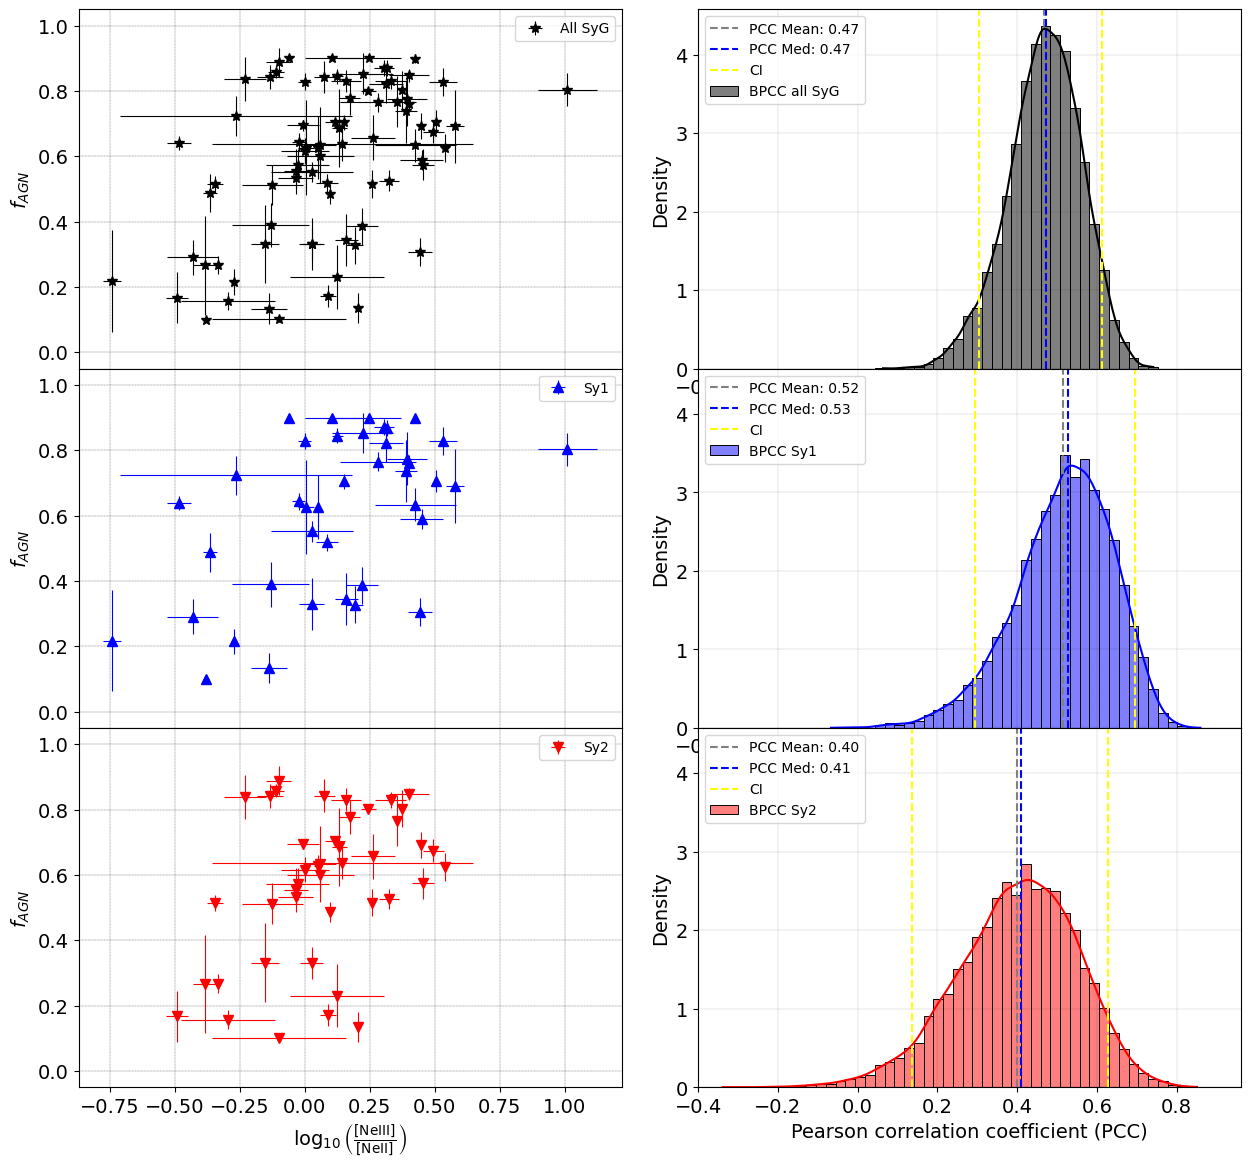

In [43]:
plt.figure(figsize=(15,14))

#plt.suptitle(r'$f_{AGN}$ vs $\frac{[NeIII]}{[NeII]}$', fontsize=16)

ax1 = plt.subplot(321)
ax1.errorbar(NeIIINeII_Sy['log_[NeIII]/[NeII]'], NeIIINeII_Sy['bayes.agn.fracAGN'],NeIIINeII_Sy['bayes.agn.fracAGN_err'], NeIIINeII_Sy['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='k*',label='All SyG')
ax1.set_ylabel(yl_label, fontsize=fontsize_labels)
ax1.set_ylim(-0.05,1.05)
ax1.legend()
ax1.grid(color='k', linestyle='--', linewidth=0.2)

ax2 = plt.subplot(323,sharex=ax1,sharey=ax1)
ax2.errorbar(NeIIINeII_Sy1['log_[NeIII]/[NeII]'], NeIIINeII_Sy1['bayes.agn.fracAGN'],NeIIINeII_Sy1['bayes.agn.fracAGN_err'], NeIIINeII_Sy1['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax2.set_ylabel(yl_label, fontsize=fontsize_labels)
ax2.legend()
ax2.grid(color='k', linestyle='--', linewidth=0.2)

ax3 = plt.subplot(325,sharex=ax1,sharey=ax1)
ax3.errorbar(NeIIINeII_Sy2['log_[NeIII]/[NeII]'], NeIIINeII_Sy2['bayes.agn.fracAGN'],NeIIINeII_Sy2['bayes.agn.fracAGN_err'], NeIIINeII_Sy2['log_[NeIII]/[NeII]_err'],
             markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax3.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeIII]}}{\mathregular{[NeII]}}\right)$', fontsize=fontsize_labels)
ax3.set_ylabel(yl_label, fontsize=fontsize_labels)
ax3.legend()
ax3.grid(color='k', linestyle='--', linewidth=0.2)

bins = np.linspace(-0.3,0.9,50)

ax4 = plt.subplot(322)
sns.histplot(NeIIINeII_fracAGN_Sy[0],kde=True,bins=bins,stat=stat,color='k',ax=ax4,label='BPCC all SyG')
ax4.axvline(x=NeIIINeII_fracAGN_Sy[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy[1])
ax4.axvline(x=NeIIINeII_fracAGN_Sy[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy[3])
ax4.axvline(x=NeIIINeII_fracAGN_Sy[4],ls='--',color='yellow',label='CI')
ax4.axvline(x=NeIIINeII_fracAGN_Sy[5],ls='--',color='yellow')
ax4.set_ylabel(yr_label,fontsize=fontsize_labels)
ax4.legend()
ax4.grid(color='k', linestyle='--', linewidth=0.1)

ax5 = plt.subplot(324,sharex=ax4,sharey=ax4)
sns.histplot(NeIIINeII_fracAGN_Sy1[0],kde=True,bins=bins,stat=stat,color='b',ax=ax5,label='BPCC Sy1')
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy1[1])
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy1[3])
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[4],ls='--',color='yellow',label='CI')
ax5.axvline(x=NeIIINeII_fracAGN_Sy1[5],ls='--',color='yellow')
ax5.set_ylabel(yr_label,fontsize=fontsize_labels)
ax5.legend()
ax5.grid(color='k', linestyle='--', linewidth=0.1)

ax6 = plt.subplot(326,sharex=ax4,sharey=ax4)
sns.histplot(NeIIINeII_fracAGN_Sy2[0],kde=True,bins=bins,stat=stat,color='r',ax=ax6,label='BPCC Sy2')
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[1],ls='--',color='gray',label='PCC Mean: %.2f' %NeIIINeII_fracAGN_Sy2[1])
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[3],ls='--',color='blue',label='PCC Med: %.2f' %NeIIINeII_fracAGN_Sy2[3])
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[4],ls='--',color='yellow',label='CI')
ax6.axvline(x=NeIIINeII_fracAGN_Sy2[5],ls='--',color='yellow')
ax6.set_xlabel(xr_label,fontsize=fontsize_labels)
ax6.set_ylabel(yr_label,fontsize=fontsize_labels)
ax6.legend()
ax6.grid(color='k', linestyle='--', linewidth=0.1)

plt.subplots_adjust(hspace=0.0,wspace=0.14) #Space between subplots
plt.savefig(path_graphs+'NeIII_NeII_vs_fracAGN_Sy1_vs_Sy2.jpg')

## [NeIII]/[NeII] vs other variables (outputs from CIGALE)

In [44]:
NeIIINeII_corr_SFR_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['log_bayes.sfh.sfr'])
NeIIINeII_corr_SFR_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['log_bayes.sfh.sfr'])
NeIIINeII_corr_SFR_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['log_bayes.sfh.sfr'])

NeIIINeII_corr_m_star_Sy = df_NeIIINeII_Sy['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy['log_bayes.stellar.m_star'])
NeIIINeII_corr_m_star_Sy1 = df_NeIIINeII_Sy1['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy1['log_bayes.stellar.m_star'])
NeIIINeII_corr_m_star_Sy2 = df_NeIIINeII_Sy2['log_[NeIII]/[NeII]'].corr(df_NeIIINeII_Sy2['log_bayes.stellar.m_star'])

print('\nPearson\'s correlation coefficient between [NeIII]/[NeII] ratio and Star Forming Rate:')
print('Total Sample: ',NeIIINeII_corr_SFR_Sy)
print('Seyfert 1: ',NeIIINeII_corr_SFR_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_SFR_Sy2)

print('\nPearson\'s correlation coefficient between [NeIII]/[NeII] ratio and Star Mass:')
print('Total Sample: ',NeIIINeII_corr_m_star_Sy)
print('Seyfert 1: ',NeIIINeII_corr_m_star_Sy1)
print('Seyfert 2: ',NeIIINeII_corr_m_star_Sy2)


Pearson's correlation coefficient between [NeIII]/[NeII] ratio and Star Forming Rate:
Total Sample:  -0.08315321048588233
Seyfert 1:  0.008154627162793398
Seyfert 2:  -0.25891809017066697

Pearson's correlation coefficient between [NeIII]/[NeII] ratio and Star Mass:
Total Sample:  0.08700739945450907
Seyfert 1:  0.2905797350759824
Seyfert 2:  -0.26544656297084085


--------------------------

# Galaxies according to their viewing angle (i from CIGALE)

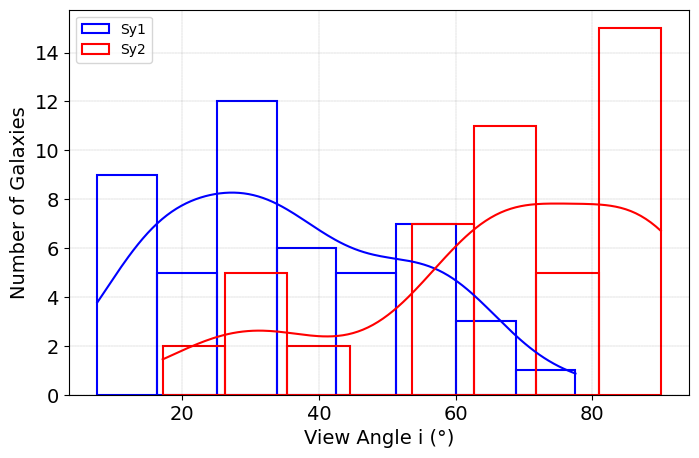

In [45]:
i_Sy1 = Ne_Sy1['bayes.agn.i']
i_Sy2 = Ne_Sy2['bayes.agn.i']
i_SyG = Ne_SyG['bayes.agn.i']
#bins_Sy = np.linspace(min(Ne_Sy['bayes.agn.i']),max(Ne_Sy['bayes.agn.i']),10)#len(Ne_Sy)
bins_Sy = freedman_diaconis(Ne_Sy['log_bayes.agn.disk_luminosity'])
plt.figure(figsize=(8,5))
sns.histplot(i_Sy1,kde=True,bins=bins_Sy,fill=False,label='Sy1',color='b')
sns.histplot(i_Sy2,kde=True,bins=bins_Sy,fill=False,label='Sy2',color='r')

plt.xlabel(r'View Angle i (°)',fontsize=14)
plt.ylabel(r'Number of Galaxies',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.legend()
plt.savefig(path_graphs+'hist_view_angle.jpg')

In [46]:
ks_2samp(i_Sy1,i_Sy2)

KstestResult(statistic=0.662677304964539, pvalue=2.6260704721892125e-10)

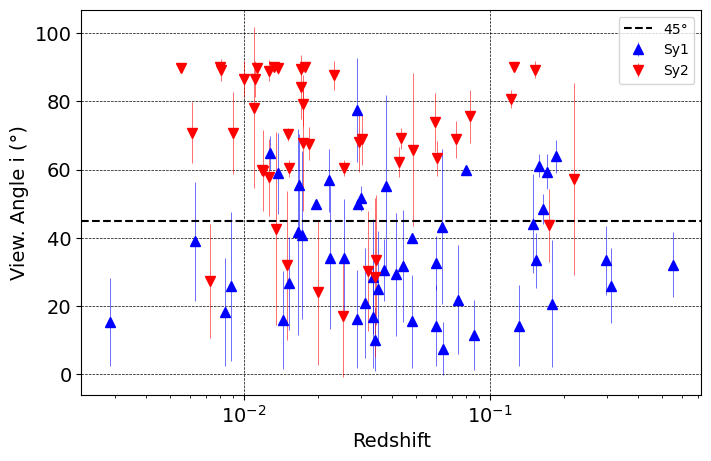

In [47]:
plt.figure(figsize=(8,5))
plt.errorbar(Ne_Sy1['redshift'],Ne_Sy1['bayes.agn.i'],Ne_Sy1['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='b^',label='Sy1')
plt.errorbar(Ne_Sy2['redshift'],Ne_Sy2['bayes.agn.i'],Ne_Sy2['bayes.agn.i_err'],markersize=7,elinewidth=0.4,fmt='rv',label='Sy2')
plt.axhline(y=45,ls='--',color='black', label='45°')
plt.xlabel(r'Redshift',fontsize=14)
plt.xscale('log')
plt.ylabel(r'View. Angle i (°)',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.savefig(path_graphs+'view_angle_vs_redshift.jpg')

### Classifying the galaxies by their viewing angle:

In [48]:
AGN_T1 = Ne_Sy[Ne_Sy['bayes.agn.i']<45]
AGN_T2 = Ne_Sy[Ne_Sy['bayes.agn.i']>45]

df_AGN_T1 = AGN_T1.to_pandas()
df_AGN_T2 = AGN_T2.to_pandas()

In [49]:
print('For the',len(AGN_T1),'galaxies with i<45°,',len(AGN_T1[AGN_T1['otype']=='Sy1']),'are Seyfert 1 and',\
     len(AGN_T1[AGN_T1['otype']=='Sy2']),'are Seyfert 2')

print('For the',len(AGN_T2),'galaxies with i>45°,',len(AGN_T2[AGN_T2['otype']=='Sy2']),'are Seyfert 2 and',\
     len(AGN_T2[AGN_T2['otype']=='Sy1']),'are Seyfert 1')

For the 43 galaxies with i<45°, 34 are Seyfert 1 and 9 are Seyfert 2
For the 52 galaxies with i>45°, 38 are Seyfert 2 and 14 are Seyfert 1


### [NeV]/[NeII] vs $f_{AGN}$ by their viewing angle

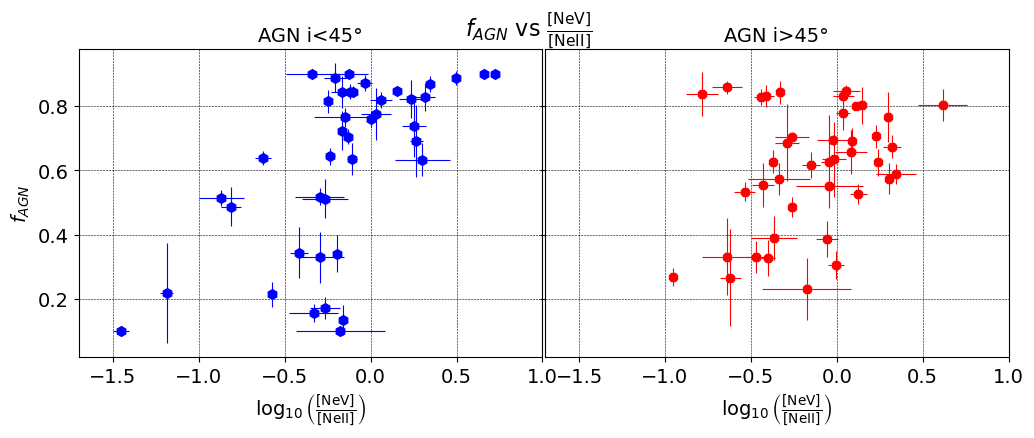

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4),sharey=True)
fig.suptitle(r'$f_{AGN}$ vs $\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}$', fontsize=16)

ax1.errorbar(AGN_T1['log_[NeV]/[NeII]'], AGN_T1['bayes.agn.fracAGN'],\
             AGN_T1['bayes.agn.fracAGN_err'], AGN_T1['log_[NeV]/[NeII]_err'],markersize=7,elinewidth=0.8,fmt='bh')
ax1.set_xlim(-1.7,1)
ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_ylabel(r'$f_{AGN}$', fontsize=14)
ax1.set_title('AGN i<45°', fontsize=14)

ax2.errorbar(AGN_T2['log_[NeV]/[NeII]'], AGN_T2['bayes.agn.fracAGN'],\
             AGN_T2['bayes.agn.fracAGN_err'], AGN_T2['log_[NeV]/[NeII]_err'],markersize=7,elinewidth=0.8,fmt='r8')
ax2.set_xlim(-1.7,1)
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax2.set_title('AGN i>45°', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.005) #Space between subplots

In [51]:
NeVNeII_corr_AGNT1 = df_AGN_T1['log_[NeV]/[NeII]'].corr(df_AGN_T1['bayes.agn.fracAGN'])
NeVNeII_corr_AGNT2 = df_AGN_T2['log_[NeV]/[NeII]'].corr(df_AGN_T2['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('AGN i<45°: ',NeVNeII_corr_AGNT1)
print('AGN i>45°: ',NeVNeII_corr_AGNT2)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
AGN i<45°:  0.619914940393564
AGN i>45°:  0.3230889388395862


Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 34 of 43
Number of samples: 10000
Median: 0.6190475966278097
Mean: 0.6148072599509044
Variance: 0.00886144348018353
Standard Desviation: 0.09413524037353668
90 % confidence interval: 0.45482210033579606 - 0.7606602345272403


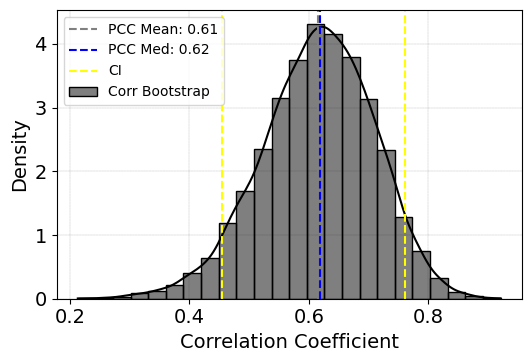

In [52]:
NeVNeII_fracAGN_AGNT1 = bsc.bootstrapCorr(10000,0.8,df_AGN_T1,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 42 of 52
Number of samples: 10000
Median: 0.32558894209615763
Mean: 0.3181205543372629
Variance: 0.032340638378474236
Standard Desviation: 0.1798350310102963
90 % confidence interval: 0.01325684802790937 - 0.5978023417998556


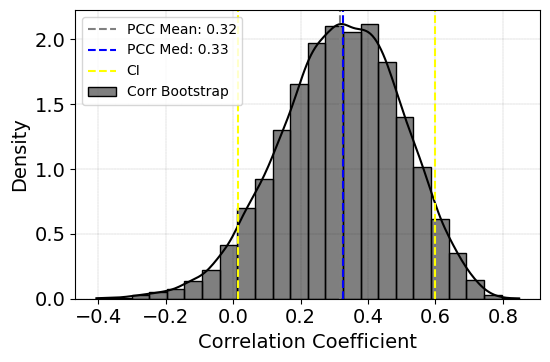

In [53]:
NeVNeII_fracAGN_AGNT2 = bsc.bootstrapCorr(10000,0.8,df_AGN_T2,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

---------------------
# Galaxies according to their AGN disc luminosity $\left(L^{disc}_{AGN} \right)$


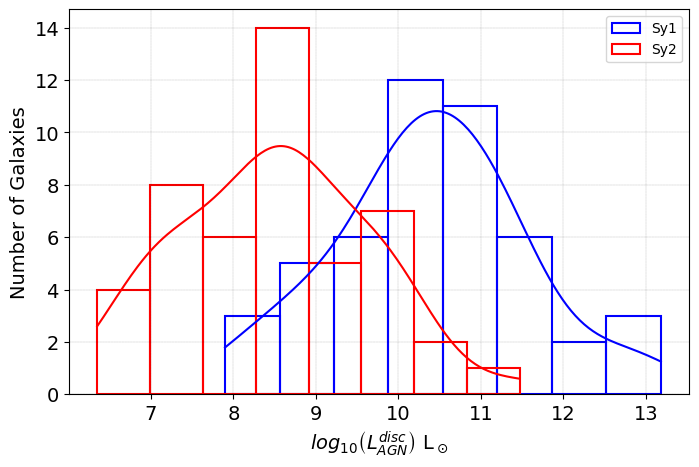

In [54]:
L_Sy1 = Ne_Sy1['log_bayes.agn.disk_luminosity']
L_Sy2 = Ne_Sy2['log_bayes.agn.disk_luminosity']
#bins_Sy = np.linspace(min(Ne_Sy['log_bayes.agn.disk_luminosity']),max(Ne_Sy['log_bayes.agn.disk_luminosity']),10)#len(Ne_Sy)
bins_Sy = freedman_diaconis(Ne_Sy['log_bayes.agn.disk_luminosity'])
plt.figure(figsize=(8,5))
sns.histplot(L_Sy1,kde=True,bins=bins_Sy,fill=False,label='Sy1',color='b')
sns.histplot(L_Sy2,kde=True,bins=bins_Sy,fill=False,label='Sy2',color='r')
plt.xlabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
plt.ylabel(r'Number of Galaxies',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.legend()
plt.savefig(path_graphs+'hist_AGN_disc_Lum_Sy.jpg')

In [55]:
ks_2samp(L_Sy1,L_Sy2)

KstestResult(statistic=0.6227836879432624, pvalue=2.2478208183684956e-09)

### $L^{disc}_{AGN}$ vs Redshift

Ramos et al. (2021) define a separation limit with the median values of the separation between Seyfert type as linear relation:

\begin{equation}
    \log \left(L^{disc}_{AGN} \right) = (9.20 \pm 0.08) + (8.67 \pm 0.61) \times \log(1+z)
\end{equation}

In [56]:
z = np.linspace(min(Ne_Sy['redshift']),max(Ne_Sy['redshift']),len(Ne_Sy))
L = 9.20 + 8.67*np.log10(1+z)
L_u = (9.20-0.08) + (8.67-0.61)*np.log10(1+z)
L_o = (9.20+0.08) + (8.67+0.61)*np.log10(1+z)
len(L)

95

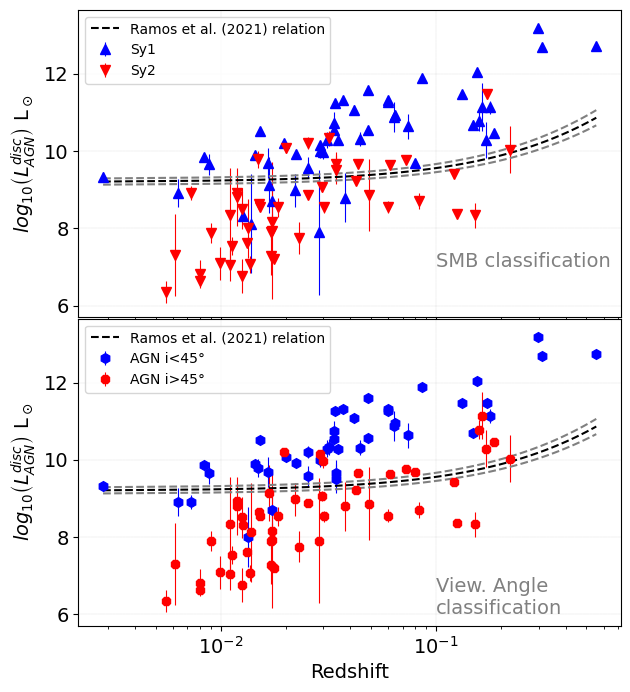

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(7,8),sharex=True)

ax1.set_xscale('log')
ax1.errorbar(Ne_Sy1['redshift'],Ne_Sy1['log_bayes.agn.disk_luminosity'],Ne_Sy1['log_bayes.agn.disk_luminosity_err'],markersize=7,elinewidth=0.8,fmt='b^',label='Sy1')
ax1.errorbar(Ne_Sy2['redshift'],Ne_Sy2['log_bayes.agn.disk_luminosity'],Ne_Sy2['log_bayes.agn.disk_luminosity_err'],markersize=7,elinewidth=0.8,fmt='rv',label='Sy2')
ax1.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax1.plot(z,L_u,ls='--',color='gray')
ax1.plot(z,L_o,ls='--',color='gray')
#ax1.set_xlabel(r'Redshift',fontsize=14)
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax1.text(1e-1,7,'SMB classification',fontsize=14,color='gray')
#ax1.set_title('Sy1 and Sy2 SMB classification', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.set_xscale('log')
ax2.errorbar(AGN_T1['redshift'],AGN_T1['log_bayes.agn.disk_luminosity'],AGN_T1['log_bayes.agn.disk_luminosity_err'],markersize=7,elinewidth=0.8,fmt='bh',label='AGN i<45°')
ax2.errorbar(AGN_T2['redshift'],AGN_T2['log_bayes.agn.disk_luminosity'],AGN_T2['log_bayes.agn.disk_luminosity_err'],markersize=7,elinewidth=0.8,fmt='r8',label='AGN i>45°')
ax2.plot(z,L,ls='--',color='black',label='Ramos et al. (2021) relation')
ax2.plot(z,L_u,ls='--',color='gray')
ax2.plot(z,L_o,ls='--',color='gray')
ax2.set_xlabel(r'Redshift',fontsize=14)
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$',fontsize=14)
ax2.text(1e-1,6,'View. Angle \nclassification',fontsize=14,color='gray')
#ax2.set_title('View. Angle classification', fontsize=14)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

plt.subplots_adjust(hspace=0.005) #Space between subplots
plt.savefig(path_graphs+'AGN_disc_L_vs_reshift.jpg')

### Classifying the galaxies by their AGN disc luminosity:

In [58]:
AGN_T1_L = Ne_Sy[Ne_Sy['log_bayes.agn.disk_luminosity'] > 9.20 + 8.67*np.log10(1+Ne_Sy['redshift'])]
AGN_T2_L = Ne_Sy[Ne_Sy['log_bayes.agn.disk_luminosity'] < 9.20 + 8.67*np.log10(1+Ne_Sy['redshift'])]

df_AGN_T1_L = AGN_T1_L.to_pandas()
df_AGN_T2_L = AGN_T2_L.to_pandas()

In [59]:
print('For the',len(AGN_T1_L),'galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity \
relation,',len(AGN_T1_L[AGN_T1_L['otype']=='Sy1']),'\nare Seyfert1 and',len(AGN_T1[AGN_T1['otype']=='Sy2']),\
      'are Seyfert2')

print('For the',len(AGN_T2_L),'galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity \
relation,',len(AGN_T2_L[AGN_T2_L['otype']=='Sy2']),'\nare Seyfert2 and',len(AGN_T2_L[AGN_T2_L['otype']=='Sy1']),\
      'are Seyfert1')

For the 51 galaxies with their AGN disc luminosity > than the Ramos et al. (2021) luminosity relation, 40 
are Seyfert1 and 9 are Seyfert2
For the 44 galaxies with their AGN disc luminosity < than the Ramos et. al (2021) lumionosity relation, 36 
are Seyfert2 and 8 are Seyfert1


Just to check if we did the classification correctly, we will graph again the $L^{disc}_{AGN}$ vs Redshift:

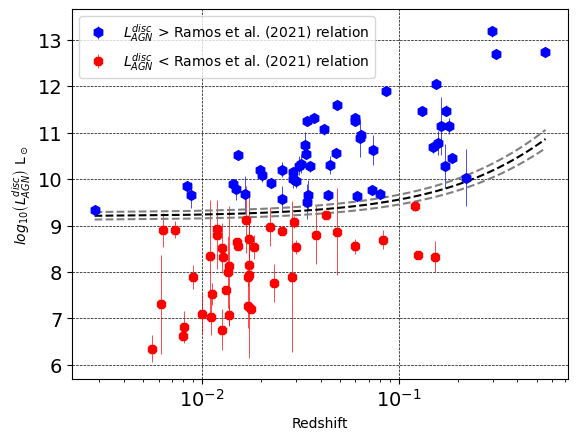

In [60]:
plt.figure()

plt.errorbar(AGN_T1_L['redshift'],AGN_T1_L['log_bayes.agn.disk_luminosity'],AGN_T1_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='bh',label=r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation')
plt.errorbar(AGN_T2_L['redshift'],AGN_T2_L['log_bayes.agn.disk_luminosity'],AGN_T2_L['log_bayes.agn.disk_luminosity_err'],
             markersize=7,elinewidth=0.5,fmt='r8',label=r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation')

plt.plot(z,L,ls='--',color='black')
plt.plot(z,L_u,ls='--',color='gray')
plt.plot(z,L_o,ls='--',color='gray')

plt.xlabel(r'Redshift')
plt.xscale('log')
plt.ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$')
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()

### [NeV]/[NeII] vs $f_{AGN}$ by their AGN disc luminosity:

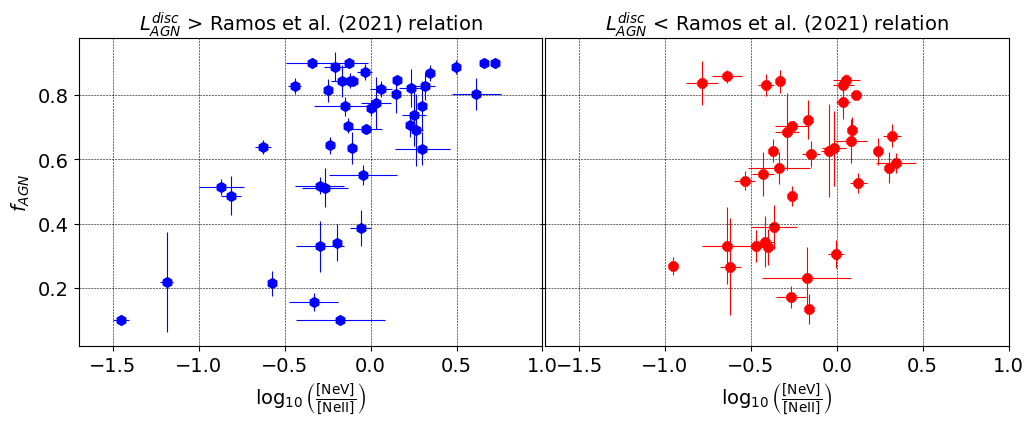

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4),sharey=True)
#fig.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)
ax1.scatter(AGN_T1_L['log_[NeV]/[NeII]'],AGN_T1_L['bayes.agn.fracAGN'],50,color='blue',marker = 'h')
ax1.errorbar(AGN_T1_L['log_[NeV]/[NeII]'], AGN_T1_L['bayes.agn.fracAGN'],\
             AGN_T1_L['bayes.agn.fracAGN_err'], AGN_T1_L['log_[NeV]/[NeII]_err'],elinewidth=0.8,fmt='b.')
ax1.set_xlim(-1.7,1)
ax1.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_ylabel(r'$f_{AGN}$', fontsize=14)
ax1.set_title(r'$L^{disc}_{AGN}$ > Ramos et al. (2021) relation', fontsize=14)
ax2.scatter(AGN_T2_L['log_[NeV]/[NeII]'], AGN_T2_L['bayes.agn.fracAGN'],50, color='red', marker = '8')
ax2.errorbar(AGN_T2_L['log_[NeV]/[NeII]'], AGN_T2_L['bayes.agn.fracAGN'],\
             AGN_T2_L['bayes.agn.fracAGN_err'], AGN_T2_L['log_[NeV]/[NeII]_err'],elinewidth=0.8,fmt='r.')
ax2.set_xlim(-1.7,1)
ax2.set_xlabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax2.set_title(r'$L^{disc}_{AGN}$ < Ramos et al. (2021) relation', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.005) #Space between subplots

In [62]:
NeVNeII_corr_AGNT1_L = df_AGN_T1_L['log_[NeV]/[NeII]'].corr(df_AGN_T1_L['bayes.agn.fracAGN'])
NeVNeII_corr_AGNT2_L = df_AGN_T2_L['log_[NeV]/[NeII]'].corr(df_AGN_T2_L['bayes.agn.fracAGN'])

print('Pearson\'s correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:')
print('AGN disc luminosty > Ramos et al. 2021 adjusment: ',NeVNeII_corr_AGNT1_L)
print('AGN disc luminosty < Ramos et al. 2021 adjusment: ',NeVNeII_corr_AGNT2_L)

Pearson's correlation coefficient between [NeV]/[NeII] ratio and AGN fraction:
AGN disc luminosty > Ramos et al. 2021 adjusment:  0.6273831595206586
AGN disc luminosty < Ramos et al. 2021 adjusment:  0.26208150585004863


Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 41 of 51
Number of samples: 10000
Median: 0.6271208071996133
Mean: 0.6163442209858173
Variance: 0.011391556923627151
Standard Desviation: 0.10673123686919003
90 % confidence interval: 0.42435800886707237 - 0.7733160847657455


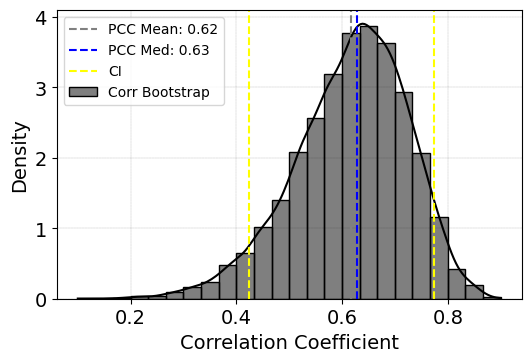

In [63]:
NeVNeII_fracAGN_AGNT1_L = bsc.bootstrapCorr(10000,0.8,df_AGN_T1_L,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

Bootstraps results for the correlation coefficient between log_[NeV]/[NeII] y bayes.agn.fracAGN :
Samples lenght: 35 of 44
Number of samples: 10000
Median: 0.270916089699843
Mean: 0.2654933083732731
Variance: 0.030171386683404317
Standard Desviation: 0.17369912689303973
90 % confidence interval: -0.02646650862747947 - 0.5453137697025425


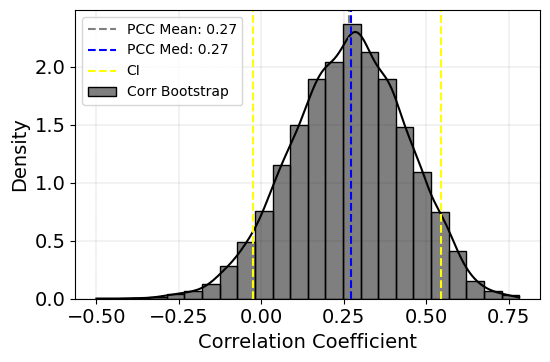

In [64]:
NeVNeII_fracAGN_AGNT2_L = bsc.bootstrapCorr(10000,0.8,df_AGN_T2_L,'log_[NeV]/[NeII]','bayes.agn.fracAGN',kdehisto=True)

--------------------------

## $L^{disc}_{AGN}$ vs $i$

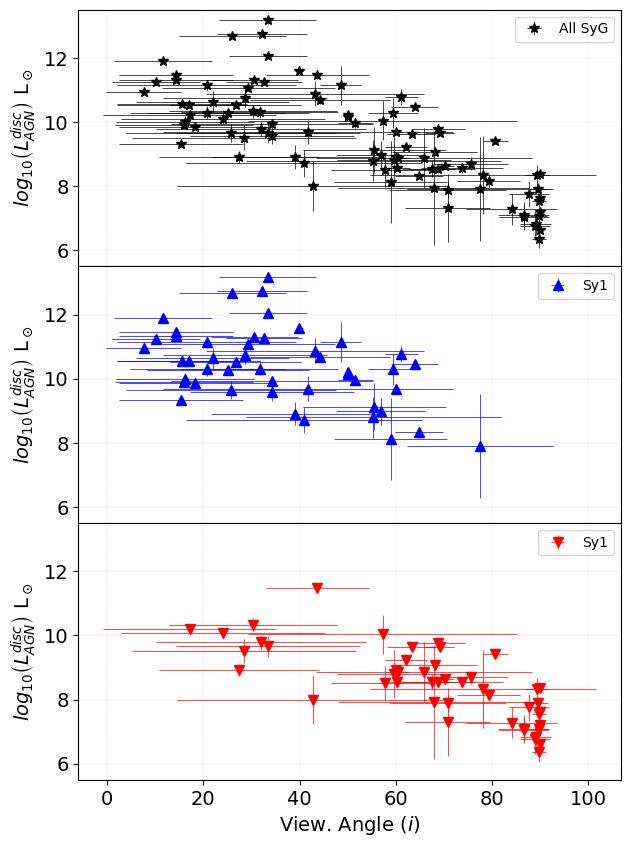

In [65]:
fig, (ax1, ax2, ax3,) = plt.subplots(3,1,figsize=(7,10),sharex=True)
#fig.suptitle(r'$f_{AGN}$ vs $\frac{[NeV]}{[NeII]}$', fontsize=16)

ax1.errorbar(Ne_Sy['bayes.agn.i'], Ne_Sy['log_bayes.agn.disk_luminosity'],Ne_Sy['log_bayes.agn.disk_luminosity_err'], Ne_Sy['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='k*',label='All SyG')
ax1.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax1.set_ylim(5.5,13.5)
ax1.grid(color='k', linestyle='--', linewidth=0.05)
ax1.legend()

ax2.errorbar(Ne_Sy1['bayes.agn.i'], Ne_Sy1['log_bayes.agn.disk_luminosity'],Ne_Sy1['log_bayes.agn.disk_luminosity_err'], Ne_Sy1['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='b^',label='Sy1')
ax2.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax2.set_ylim(5.5,13.5)
ax2.grid(color='k', linestyle='--', linewidth=0.05)
ax2.legend()

ax3.errorbar(Ne_Sy2['bayes.agn.i'], Ne_Sy2['log_bayes.agn.disk_luminosity'],Ne_Sy2['log_bayes.agn.disk_luminosity_err'], Ne_Sy2['bayes.agn.i_err'],
             markersize=7,elinewidth=0.5,fmt='rv',label='Sy1')
ax3.set_ylabel(r'$log_{10}\left(L^{disc}_{AGN}\right)$ L$_\odot$', fontsize=14)
ax3.set_xlabel(r'View. Angle ($i$)', fontsize=14)
ax3.set_ylim(5.5,13.5)
ax3.grid(color='k', linestyle='--', linewidth=0.05)
ax3.legend()

plt.subplots_adjust(hspace=0.001) #Space between subplots

Bootstraps results for the correlation coefficient between bayes.agn.i y log_bayes.agn.disk_luminosity :
Samples lenght: 76 of 95
Number of samples: 10000
Median: -0.7777724727515727
Mean: -0.7753201877516517
Variance: 0.0015606126440178946
Standard Desviation: 0.039504590163902405
90 % confidence interval: -0.8350968615193823 - -0.70566933579805


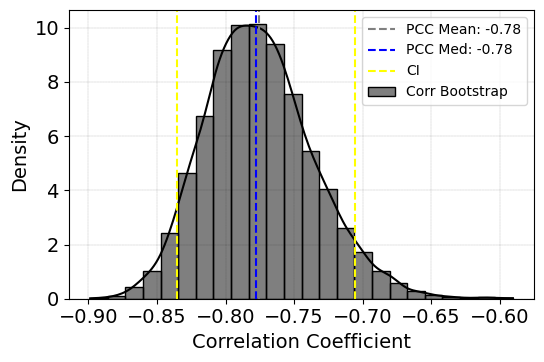

In [66]:
LAGNdisc_i_Sy = bsc.bootstrapCorr(10000,0.8,df_Ne_Sy,'bayes.agn.i','log_bayes.agn.disk_luminosity',kdehisto=True)

---------------------------

## Skymap

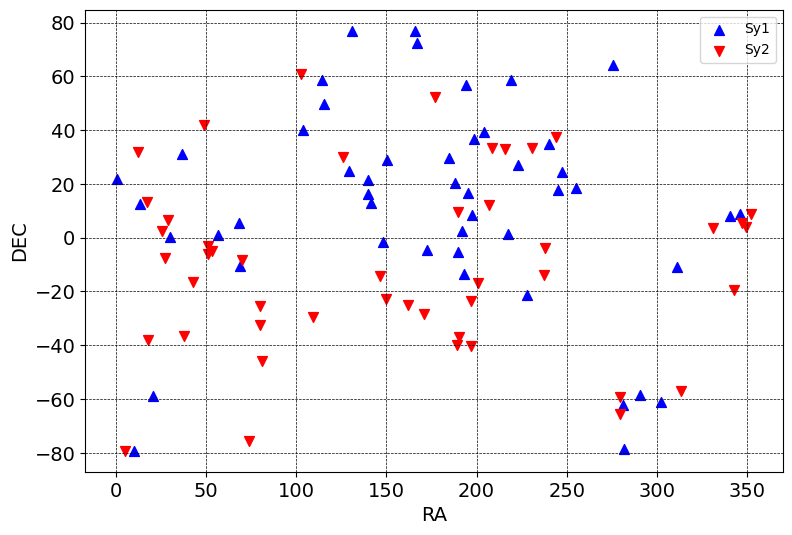

In [67]:
plt.figure(figsize=(9,6))
plt.scatter(Ne_Sy1['RA'], Ne_Sy1['DEC'],50,color='blue', marker = '^', label='Sy1')
plt.scatter(Ne_Sy2['RA'], Ne_Sy2['DEC'],50,color='red', marker = 'v', label='Sy2')
plt.xlabel(r'RA', fontsize=14)
plt.ylabel(r'DEC', fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

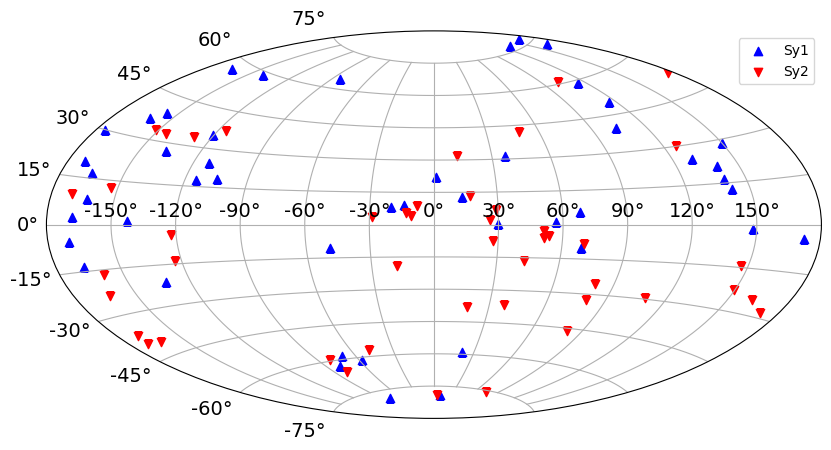

In [68]:
coordinates_Sy1= SkyCoord(ra=Ne_Sy1['RA'], dec=Ne_Sy1['DEC'],unit='deg',frame='icrs')
coordinates_Sy2= SkyCoord(ra=Ne_Sy2['RA'], dec=Ne_Sy2['DEC'],unit='deg',frame='icrs')

plt.figure(figsize=(10,7))
plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(coordinates_Sy1.ra.wrap_at('180d').radian, coordinates_Sy1.dec.radian,\
            color='blue', marker = '^', label='Sy1')
plt.scatter(coordinates_Sy2.ra.wrap_at('180d').radian, coordinates_Sy2.dec.radian,\
            color='red', marker = 'v', label='Sy2')
plt.legend()
plt.show()

## Redshift Distribution

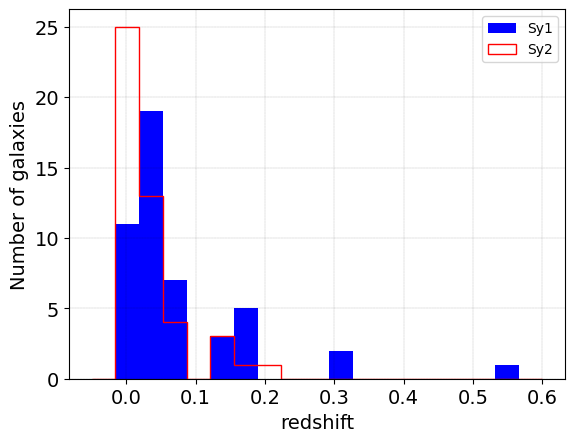

In [69]:
z_Sy1 = Ne_Sy1['redshift']
z_Sy2 = Ne_Sy2['redshift']
#z_SyG = Ne_SyG['redshift']
bins_Sy = np.linspace(-0.05,0.6,20)
plt.figure()
plt.hist(z_Sy1, bins=bins_Sy,color='b', label='Sy1')
plt.hist(z_Sy2, bins=bins_Sy, histtype='step',color='r', label='Sy2')
plt.xlabel('redshift',fontsize=14)
plt.ylabel(r'Number of galaxies',fontsize=14)
plt.grid(color='k', linestyle='--', linewidth=0.1)
#plt.yscale('log')
plt.legend()

In [70]:
print('Min redshift value for Sy1:',min(z_Sy1),'. Max redshift value for Sy1:',max(z_Sy1))
print('Min redshift value for Sy2:',min(z_Sy2),'. Max redshift value for Sy2:',max(z_Sy2))

Min redshift value for Sy1: 0.002838630450136274 . Max redshift value for Sy1: 0.55517
Min redshift value for Sy2: 0.005554 . Max redshift value for Sy2: 0.22


---------------------------
## Alternative graphic for [NeV/NeII] vs AGN Frac:

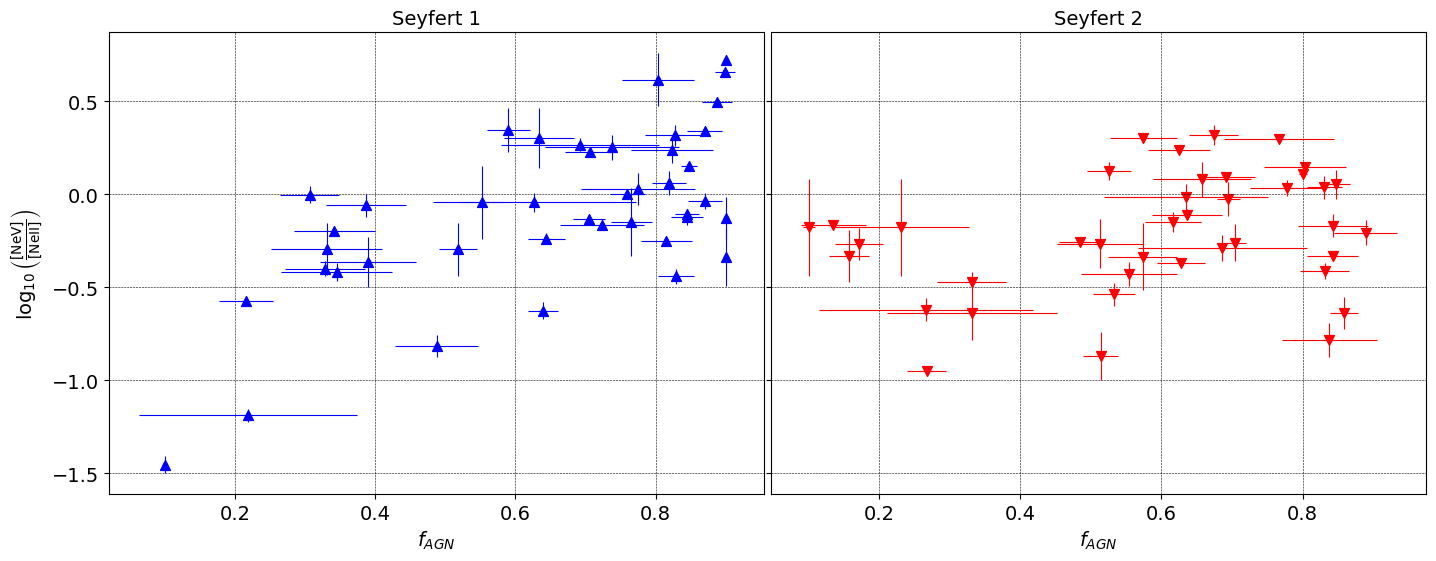

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(17,6),sharey=True)
#fig.suptitle(r'$\frac{[NeV]}{[NeII]}$ vs $f_{AGN}$', fontsize=16)
ax1.scatter(NeVNeII_Sy1['bayes.agn.fracAGN'],NeVNeII_Sy1['log_[NeV]/[NeII]'],50,color='blue',marker = '^')
ax1.errorbar(NeVNeII_Sy1['bayes.agn.fracAGN'], NeVNeII_Sy1['log_[NeV]/[NeII]'],\
             NeVNeII_Sy1['log_[NeV]/[NeII]_err'], NeVNeII_Sy1['bayes.agn.fracAGN_err'],elinewidth=0.8,fmt='b.')
ax1.set_xlabel(r'$f_{AGN}$', fontsize=14)
ax1.set_ylabel(r'$\log_{10}\left(\frac{\mathregular{[NeV]}}{\mathregular{[NeII]}}\right)$', fontsize=14)
ax1.set_title('Seyfert 1', fontsize=14)
ax2.scatter(NeVNeII_Sy2['bayes.agn.fracAGN'], NeVNeII_Sy2['log_[NeV]/[NeII]'],50, color='red', marker = 'v')
ax2.errorbar(NeVNeII_Sy2['bayes.agn.fracAGN'], NeVNeII_Sy2['log_[NeV]/[NeII]'], \
             NeVNeII_Sy2['log_[NeV]/[NeII]_err'], NeVNeII_Sy2['bayes.agn.fracAGN_err'],elinewidth=0.8,fmt='r.')
ax2.set_xlabel(r'$f_{AGN}$', fontsize=14)
ax2.set_title('Seyfert 2', fontsize=14)
ax1.grid(color='k', linestyle='--', linewidth=0.4)
ax2.grid(color='k', linestyle='--', linewidth=0.4)
plt.subplots_adjust(wspace=0.01) #Space between subplots

---------------------------------------

## Final numbers

In [72]:
date_sample = 'Sep_02_2022'
simbad_sample_Sy = Table.read(path_raw+'SMB_'+date_sample+'_Sy_Samples'+'.vot',format='votable') 
NeIR_Sy = Table.read(path_raw+'Obj_Sy_Ne-IR_'+date_sample+'.vot',format='votable')
CIG_BadGalaxies = Table.read('../Datos/Complementary/CIGPhot_BadEnergyBalance.tbl', format='ascii')
CIG = Table.read(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii')
out0to90 = Table.read(path_CIGALE_out+'results0a90_All.fits', format='fits')

In [73]:
print('From the',len(simbad_sample_Sy),'Seyfert Galaxies from the SIMBAD sample,',len(NeIR_Sy),'have information\n\
of Neon lines ([NeII],[NeIII] or [NeV]).\n') 

print('After remove',len(CIG_BadGalaxies),'galaxies with bad energy balance coverage, the total of galaxies \n\
to model and fit their SEDs in CIGALE was',len(CIG),'.\n')

print(r'Cleaining the',len(CIG),'galaxies from CIGALE results of the galaxies with bad fittings \n\
and a bad constrained SFR (\'pcigale.ini\' setup i = 0 to 90),',len(CIG)-len(out0to90),'galaxies \n\
was removed leaving a total of',len(out0to90),'galaxies\n')

print('Of this',len(out0to90),'galaxies, only',len(Ne_Sy),'have information from at least two different \n\
Neon spectral lines with the same bibcodes to calcule the spectral line ratios\n')

print('From the', len(Ne_Sy),'galaxies:',len(NeVNeII_Sy),'galaxies have [NeV]/[NeII] info,')
print(len(NeVNeIII_Sy),'galaxies have [NeV]/[NeIII] info and',len(NeIIINeII_Sy),'galaxies have [NeIII]/[NeII] info')

From the 44270 Seyfert Galaxies from the SIMBAD sample, 303 have information
of Neon lines ([NeII],[NeIII] or [NeV]).

After remove 51 galaxies with bad energy balance coverage, the total of galaxies 
to model and fit their SEDs in CIGALE was 252 .

Cleaining the 252 galaxies from CIGALE results of the galaxies with bad fittings 
and a bad constrained SFR ('pcigale.ini' setup i = 0 to 90), 134 galaxies 
was removed leaving a total of 118 galaxies

Of this 118 galaxies, only 95 have information from at least two different 
Neon spectral lines with the same bibcodes to calcule the spectral line ratios

From the 95 galaxies: 82 galaxies have [NeV]/[NeII] info,
80 galaxies have [NeV]/[NeIII] info and 83 galaxies have [NeIII]/[NeII] info


-------------------------------------
## Notebook Info

In [74]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.12.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-76-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

matplotlib: 3.7.1
seaborn   : 0.12.2
pandas    : 1.4.4
astropy   : 5.1
numpy     : 1.21.5

Watermark: 2.3.1



-----------------------------------------
### Cells for test


 0.7169452984183431
0.7073316513274646
0.09017785739224551
0.5446239983342581 - 0.837736760280015
19.897094977409765 0.26561225834651636 0.022248731196391355


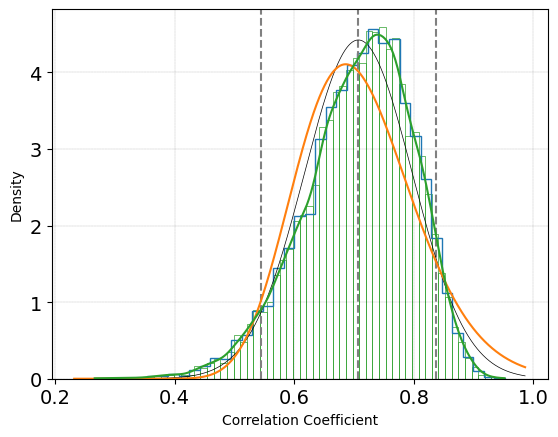

In [75]:
from scipy.stats import gamma

corrdata = []
for i in range(10000):
    sample = df_NeVNeII_Sy2.sample(frac=0.8,replace=True, random_state=i)
    corr = np.log10(sample['redshift']).corr(sample['log_bayes.agn.disk_luminosity'])
    corrdata.append(corr)

mu, std = norm.fit(corrdata)
shape, loc, scale = gamma.fit(corrdata)

bins = np.linspace(min(corrdata), max(corrdata),40)
plt.hist(corrdata, bins=bins, density=True, histtype='step')
plt.axvline(x=np.mean(corrdata),ls='--',color='gray')
plt.axvline(x=np.percentile(corrdata,5),ls='--',color='gray')
plt.axvline(x=np.percentile(corrdata,95),ls='--',color='gray')
plt.xlabel(r'Correlation Coefficient')
plt.ylabel('Density')
plt.grid(color='k', linestyle='--', linewidth=0.1)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 10000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=0.5)

# Graficar distribución gamma
plt.plot(x, gamma.pdf(x, shape, loc=loc, scale=scale))

p = sns.histplot(corrdata,kde=True,fill=False,stat=stat)

lines = p.get_lines()

for line in lines:
    x, y = line.get_data()
    #print(x[np.argmax(y)])
    #ax4.axvline(x[np.argmax(y)], ls='--', color='black')

print('\n',np.median(corrdata))
print(mu)
print(std)
print(np.percentile(corrdata,5),'-',np.percentile(corrdata,95))
print(shape, loc, scale)

-------------------------------

In [76]:
NeVNeII_Sy1['log_[NeV]/[NeII]'].info('stats') 

name = log_[NeV]/[NeII]
mean = -0.0917054
std = 0.438122
min = -1.45414
max = 0.721503
n_bad = 0
length = 42


In [77]:
NeVNeII_Sy1['Main_id','redshift','[NeV]*','[NeII]*','[NeV]/[NeII]*','log_[NeV]/[NeII]'].show_in_notebook()

idx,Main_id,redshift,[NeV]*,[NeII]*,[NeV]/[NeII]*,log_[NeV]/[NeII]
0,2E 2389,0.3115,505000000.0,437000000.0,1.1556064073226544,0.06280994114823953
1,2E 3648,0.55517,1180000000.0,660000000.0,1.7878787878787878,0.25233807176425666
2,2MASSI J0918486+211717,0.14903,4480000000.0,982000000.0,4.562118126272912,0.6591665262111943
3,2MASX J14510879+2709272,0.06449,2670000000.0,507000000.0,5.266272189349112,0.7215033020312392
4,3C 234.0,0.18494,3300000000.0,800000000.0,4.125,0.6154239528859439
5,7C 1821+6419,0.297,5080000000.0,2750000000.0,1.8472727272727272,0.26653101845365657
6,ESO 12-21,0.033396756044708376,3190000000.0,12000000000.0,0.2658333333333333,-0.5753905629904437
7,ESO 113-45,0.048174990836348686,1895000000.0,2705000000.0,0.7459908688828649,-0.12726648836922827
8,ESO 140-43,0.014360633537977563,7870000000.0,10515000000.0,0.7541167951030223,-0.12256138683498459
9,ESO 141-55,0.03710900559079442,2250000000.0,2240000000.0,1.0044642857142858,0.0019344997771997185


In [78]:
NeVNeII_Sy2['Main_id','redshift','[NeV]*','[NeII]*','[NeV]/[NeII]*','log_[NeV]/[NeII]'].show_in_notebook()

idx,Main_id,redshift,[NeV]*,[NeII]*,[NeV]/[NeII]*,log_[NeV]/[NeII]
0,2C 94,0.059615,2000000000.0,3900000000.0,0.5128205128205128,-0.29003461136251807
1,2MASX J00215355-7910077,0.072724,12300000000.0,6190000000.0,1.987075928917609,0.2982144624192799
2,2MASX J22041914+0333511,0.0611,8330000000.0,5950000000.0,1.4,0.146128035678238
3,ESO 33-2,0.018426,5570000000.0,2670000000.0,2.0861423220973783,0.31934393380915366
4,ESO 103-35,0.013249,14766666666.666666,26900000000.0,0.5490387093348666,-0.2603970350437369
5,ESO 253-3,0.042489,6810000000.0,16000000000.0,0.425625,-0.37097287074313967
6,ESO 323-77,0.014904,5440000000.0,40200000000.0,0.13532338308457711,-0.8686271533862902
7,ESO 362-18,0.012582037670874296,3210000000.0,11170000000.0,0.2903055429350295,-0.537144671908198
8,ESO 428-14,0.005554,62700000000.0,50800000000.0,1.234251968503937,0.0914038285467972
9,FRL 49,0.020020516993793088,25900000000.0,38200000000.0,0.679306653491436,-0.16793413167680576


In [79]:
Ne_Sy.show_in_notebook()

idx,Main_id,RA,DEC,otype,redshift,otypes,[NeV]*,[NeV]_err*,[NeII]*,[NeII]_err*,[NeV]/[NeII]*,[NeV]/[NeII]_err*,[NeV]$^+$,[NeV]_err$^+$,[NeIII]$^+$,[NeIII]_err$^+$,[NeV]/[NeIII]$^+$,[NeV]/[NeIII]_err$^+$,[NeIII]$^-$,[NeIII]_err$^-$,[NeII]$^-$,[NeII]_err$^-$,[NeIII]/[NeII]$^-$,[NeIII]/[NeII]_err$^-$,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,bayes.agn.disk_luminosity,bayes.agn.disk_luminosity_err,bayes.agn.luminosity,bayes.agn.luminosity_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.stellar.m_star,bayes.stellar.m_star_err,best.reduced_chi_square,log.reduced_chi_square,NED_Ne_IR_info,log_[NeV]/[NeII],log_[NeV]/[NeII]_err,log_[NeV]/[NeIII],log_[NeV]/[NeIII]_err,log_[NeIII]/[NeII],log_[NeIII]/[NeII]_err,log_bayes.sfh.sfr,log_bayes.sfh.sfr_err,log_bayes.stellar.m_star,log_bayes.stellar.m_star_err,log_bayes.agn.disk_luminosity,log_bayes.agn.disk_luminosity_err,log_bayes.agn.luminosity,log_bayes.agn.luminosity_err,log_[NeV]*,log_[NeII]*,log_[NeV]$^+$,log_[NeIII]$^+$,log_[NeIII]$^-$,log_[NeII]$^-$,log_[NeV]_err*,log_[NeII]_err*,log_[NeV]_err$^+$,log_[NeIII]_err$^+$,log_[NeIII]_err$^-$,log_[NeII]_err$^-$
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum,,,,,,,,,,,,,,,,,,solLum,solLum,solLum,solLum,,,,,,,,,,,,
0,2C 94,17.220292429510003,13.33729522217,Sy2,0.059615,*|AGN|G|Rad|Sy2|X,2000000000.0,300000000.0,3900000000.0,200000000.0,0.5128205128205128,0.0812943431354469,2000000000.0,300000000.0,5300000000.0,200000000.0,0.37735849056603776,0.05836748377170459,5300000000.0,200000000.0,3900000000.0,200000000.0,1.358974358974359,0.08652562196640158,0.6865611565783494,0.11967341436995055,73.83482561588654,8.508248513418419,360178641.6940187,133777936.61431195,63920022717.504845,10528090268.60189,1.7246193065665494,1.3163365088890544,28682725610.48474,6450427912.662605,1.3173407609701728,0.11969812990994547,NeII|NeIII|NeV,-0.29003461136251807,0.06884608503566447,-0.4232458739368078,0.06717399173026657,0.13321126257428986,0.027651441629564996,0.2366932435809116,0.331480507009068,10.457620418311992,0.0976680280119563,8.556517955930909,0.1613061213145318,10.805636920656456,0.07153144373618907,9.301029995663981,9.5910646070265,9.301029995663981,9.724275869600788,9.724275869600788,9.5910646070265,0.06514417228548777,0.022271511892474453,0.06514417228548777,0.016388471015217048,0.016388471015217048,0.022271511892474453
1,2C 1883,349.14663898619995,4.08841586141,Sy2,0.22,*|AGN|G|IR|QSO|Rad|Sy2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1000000000.0,70000000.0,3110000000.0,220000000.0,0.3215434083601286,0.03199976335108683,0.1676884426585983,0.07816057785123717,57.27044594574329,27.99390132811201,10769386347.991016,15106402904.38128,235621836865.84167,92144665660.44595,103.9120034706322,24.030265174755055,85948162689.7023,57012631337.310844,1.8403458401068076,0.26489944384462905,NeII|NeIII,nan,nan,nan,nan,-0.4927603890268375,0.04322066720777531,2.0166657182978276,0.10043316667469993,10.934236597227232,0.28808377530966245,10.032190957404381,0.6091923170723561,11.372215537349629,0.16983960555378033,nan,nan,nan,nan,9.0,9.492760389026838,nan,nan,nan,nan,0.030400613733227628,0.03072179614749691
2,2E 2389,166.0577547903,76.98283181919,Sy1,0.3115,*|BH?|G|IR|QSO|Rad|Sy1|UV|X|gam,505000000.0,59000000.0,437000000.0,40000000.0,1.1556064073226544,0.17151303566833198,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.8188987719707819,0.024258975221072464,26.011843998959925,11.071888539354369,4856685623362.674,327999406644.255,6165931772264.799,308296588613.2399,32.99957287515418,13.005716016371974,82007440862.93582,69392222513.68936,1.442908260688541,0.15923871976759285,NeII|NeV,0.06280994114823953,0.06445721007882468,nan,nan,nan,nan,1.5185083186910966,0.17116314567100893,10.913853259445968,0.3674868890868961,12.686339992199073,0.029330358894943728,12.789998714828887,0.02171472409516259,8.703291378118662,8.640481436970422,nan,nan,nan,nan,0.05073935531146902,0.039752355322952106,nan,nan,nan,nan
3,2E 3648,245.09091058141,17.60665343366,